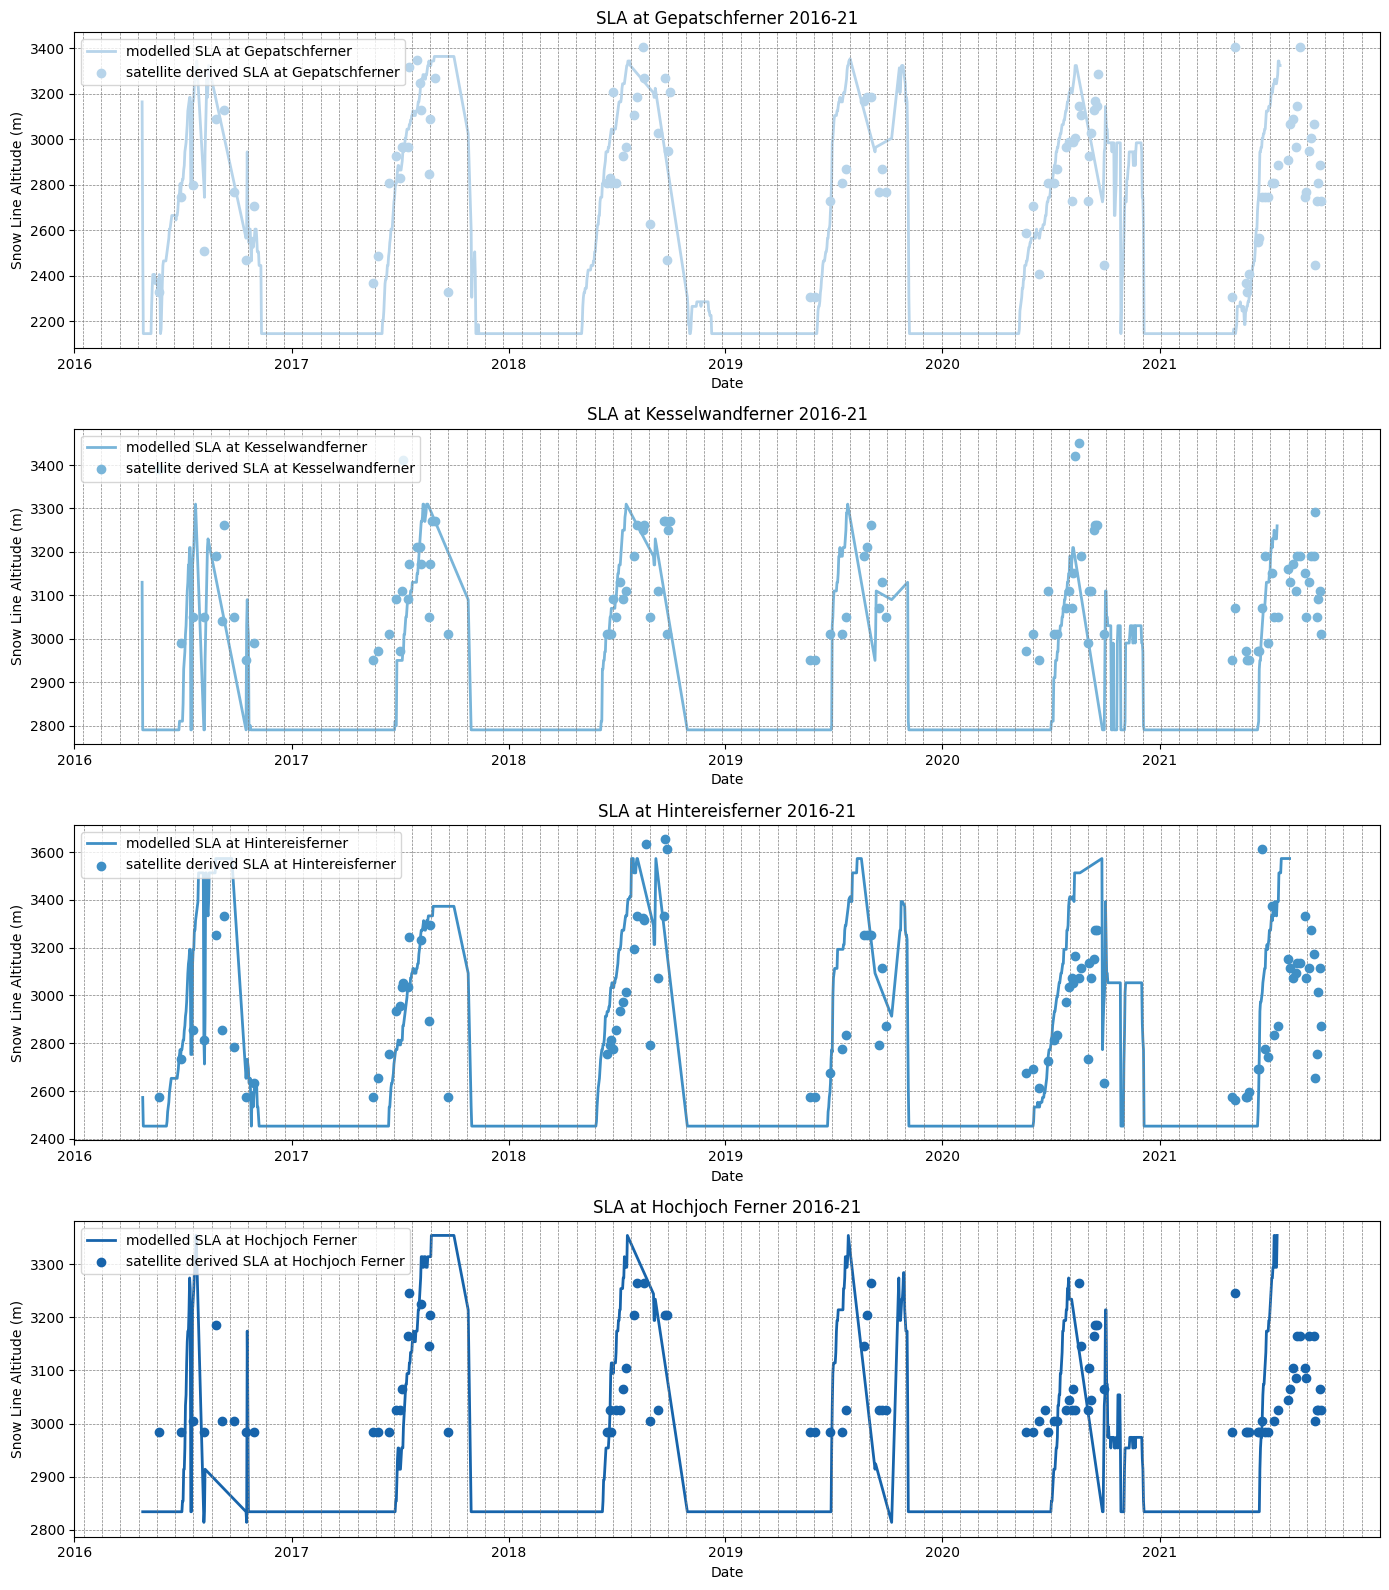

In [34]:
# joined plot für SLA über Gesamtzeitraum 

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# -------------------------------
# 1) Parameter: Pfade & Gletscher-IDs
# -------------------------------
input_folder_continuous = r"C:/Users/anne_/Desktop/Anne/SC_Rasters2016-21"  # Ordner mit kontinuierlichen CSVs
input_folder_discontinuous = r"C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv"  # Ordner mit diskontinuierlichen CSVs
output_path = r"C:/Users/anne_/Desktop/Anne/joined_SLA_2016-21.png"  # Speicherpfad für die Grafik

# Gletscher-IDs und zugehörige Namen:
gid_to_name = {
    755530: "Gepatschferner",
    755560: "Kesselwandferner",
    755531: "Hintereisferner",
    755612: "Hochjoch Ferner"
}
gids = list(gid_to_name.keys())

# -------------------------------
# 2) Farben definieren
# -------------------------------
num_glaciers = len(gids)
blues = cm.Blues(np.linspace(0.3, 0.8, num_glaciers))  # 4 Blautöne von hell bis dunkel


# -------------------------------
# 3) Subplots erstellen
# -------------------------------
fig, axs = plt.subplots(num_glaciers, 1, figsize=(14, 4 * num_glaciers))  # Breite angepasst, Höhe reduziert

# Wenn nur ein Gletscher vorhanden ist, wird axs zu einem einzelnen Ax-Objekt, daher müssen wir es in eine Liste umwandeln.
if num_glaciers == 1:
    axs = [axs]

# Iteriere über alle Gletscher
for i, gid in enumerate(gids):
    # ------------------------------
    # 1) Einlesen der kontinuierlichen SLA-Daten
    # ------------------------------
    csv_file_continuous = os.path.join(input_folder_continuous, f"snowline_results_{gid}.csv")
    df_continuous = pd.read_csv(csv_file_continuous)
    df_continuous = df_continuous[df_continuous["SLA Range (m)"] != "No SLA found"]
    if df_continuous.empty:
        print(f"Keine gültigen kontinuierlichen SLA-Daten für Gletscher {gid} in '{csv_file_continuous}'.")
        continue
    df_continuous["SLA_min"] = df_continuous["SLA Range (m)"].str.split(" - ").str[0].astype(float)
    df_continuous["SLA_max"] = df_continuous["SLA Range (m)"].str.split(" - ").str[1].astype(float)
    df_continuous["SLA_mid"] = (df_continuous["SLA_min"] + df_continuous["SLA_max"]) / 2
    df_continuous["Date"] = pd.to_datetime(df_continuous["Date"], format="%Y%m%d")
    df_continuous.sort_values(by="Date", inplace=True)

    # ------------------------------
    # 2) Einlesen der diskontinuierlichen SLA-Daten
    # ------------------------------
    csv_file_discontinuous = os.path.join(input_folder_discontinuous, f"snowline_results_{gid}.csv")
    df_discontinuous = pd.read_csv(csv_file_discontinuous)
    df_discontinuous = df_discontinuous[df_discontinuous["SLA Range (m)"] != "No SLA found"]
    if df_discontinuous.empty:
        print(f"Keine gültigen diskontinuierlichen SLA-Daten für Gletscher {gid} in '{csv_file_discontinuous}'.")
        continue
    df_discontinuous["SLA_min"] = df_discontinuous["SLA Range (m)"].str.split(" - ").str[0].astype(float)
    df_discontinuous["SLA_max"] = df_discontinuous["SLA Range (m)"].str.split(" - ").str[1].astype(float)
    df_discontinuous["SLA_mid"] = (df_discontinuous["SLA_min"] + df_discontinuous["SLA_max"]) / 2
    df_discontinuous["Date"] = pd.to_datetime(df_discontinuous["Date"], format="%Y%m%d")
    df_discontinuous = df_discontinuous[df_discontinuous["Date"] >= "2016-01-01"]
    df_discontinuous.sort_values(by="Date", inplace=True)

    # ------------------------------
    # 3) Plotten der kontinuierlichen SLA-Daten
    # ------------------------------
    axs[i].plot(
        df_continuous["Date"], 
        df_continuous["SLA_mid"],
        color=blues[i],
        linestyle="-",
        linewidth=2,
        marker=None,
        label=f"modelled SLA at {gid_to_name[gid]}"  # Statt Gletscher-ID den Namen anzeigen
    )

    # ------------------------------
    # 4) Plotten der diskontinuierlichen SLA-Daten als Punkte
    # ------------------------------
    axs[i].scatter(
        df_discontinuous["Date"], 
        df_discontinuous["SLA_mid"],
        color=blues[i], 
        label=f"satellite derived SLA at {gid_to_name[gid]}", 
        zorder=5  # Damit die Punkte über der Linie sind
    )

    # Details für jedes Subplot
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Snow Line Altitude (m)")
    axs[i].set_title(f"SLA at {gid_to_name[gid]} 2016-21")

    # Gitterlinien:
    num_vertical_lines = 72
    x_min, x_max = axs[i].get_xlim()  # Hole die x-Achsen-Grenzen (Zeitspanne)
    vertical_lines = np.linspace(x_min, x_max, num_vertical_lines)

    # Zeichne das Gitter mit den vertikalen Linien und den bestehenden horizontalen Linien
    axs[i].grid(True, which='both', axis='y', linestyle='--', color='gray', linewidth=0.5)  # horizontale Linien

    # Vertikale Gitterlinien manuell hinzufügen
    for line in vertical_lines:
        axs[i].axvline(x=line, color='gray', linestyle='--', linewidth=0.5)

    # Setze die xticks und xticklabels für die Jahre
    axs[i].set_xticks(pd.to_datetime([f"{year}-01-01" for year in range(df_continuous["Date"].dt.year.min(), df_continuous["Date"].dt.year.max() + 1)]))  # Jahresmarkierungen auf der x-Achse
    axs[i].set_xticklabels([str(year) for year in range(df_continuous["Date"].dt.year.min(), df_continuous["Date"].dt.year.max() + 1)])  # Jahreszahlen für x-Achse

    # Position der Legende anpassen (links oben)
    axs[i].legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=10)

# -------------------------------
# 5) Diagramm anpassen & Speichern
# -------------------------------
plt.tight_layout()  # Verhindert, dass die Subplots überlappen

# Grafik speichern (z. B. als PNG in hoher Auflösung)
plt.savefig(output_path, dpi=300)

# Optional: Plot anzeigen
plt.show()


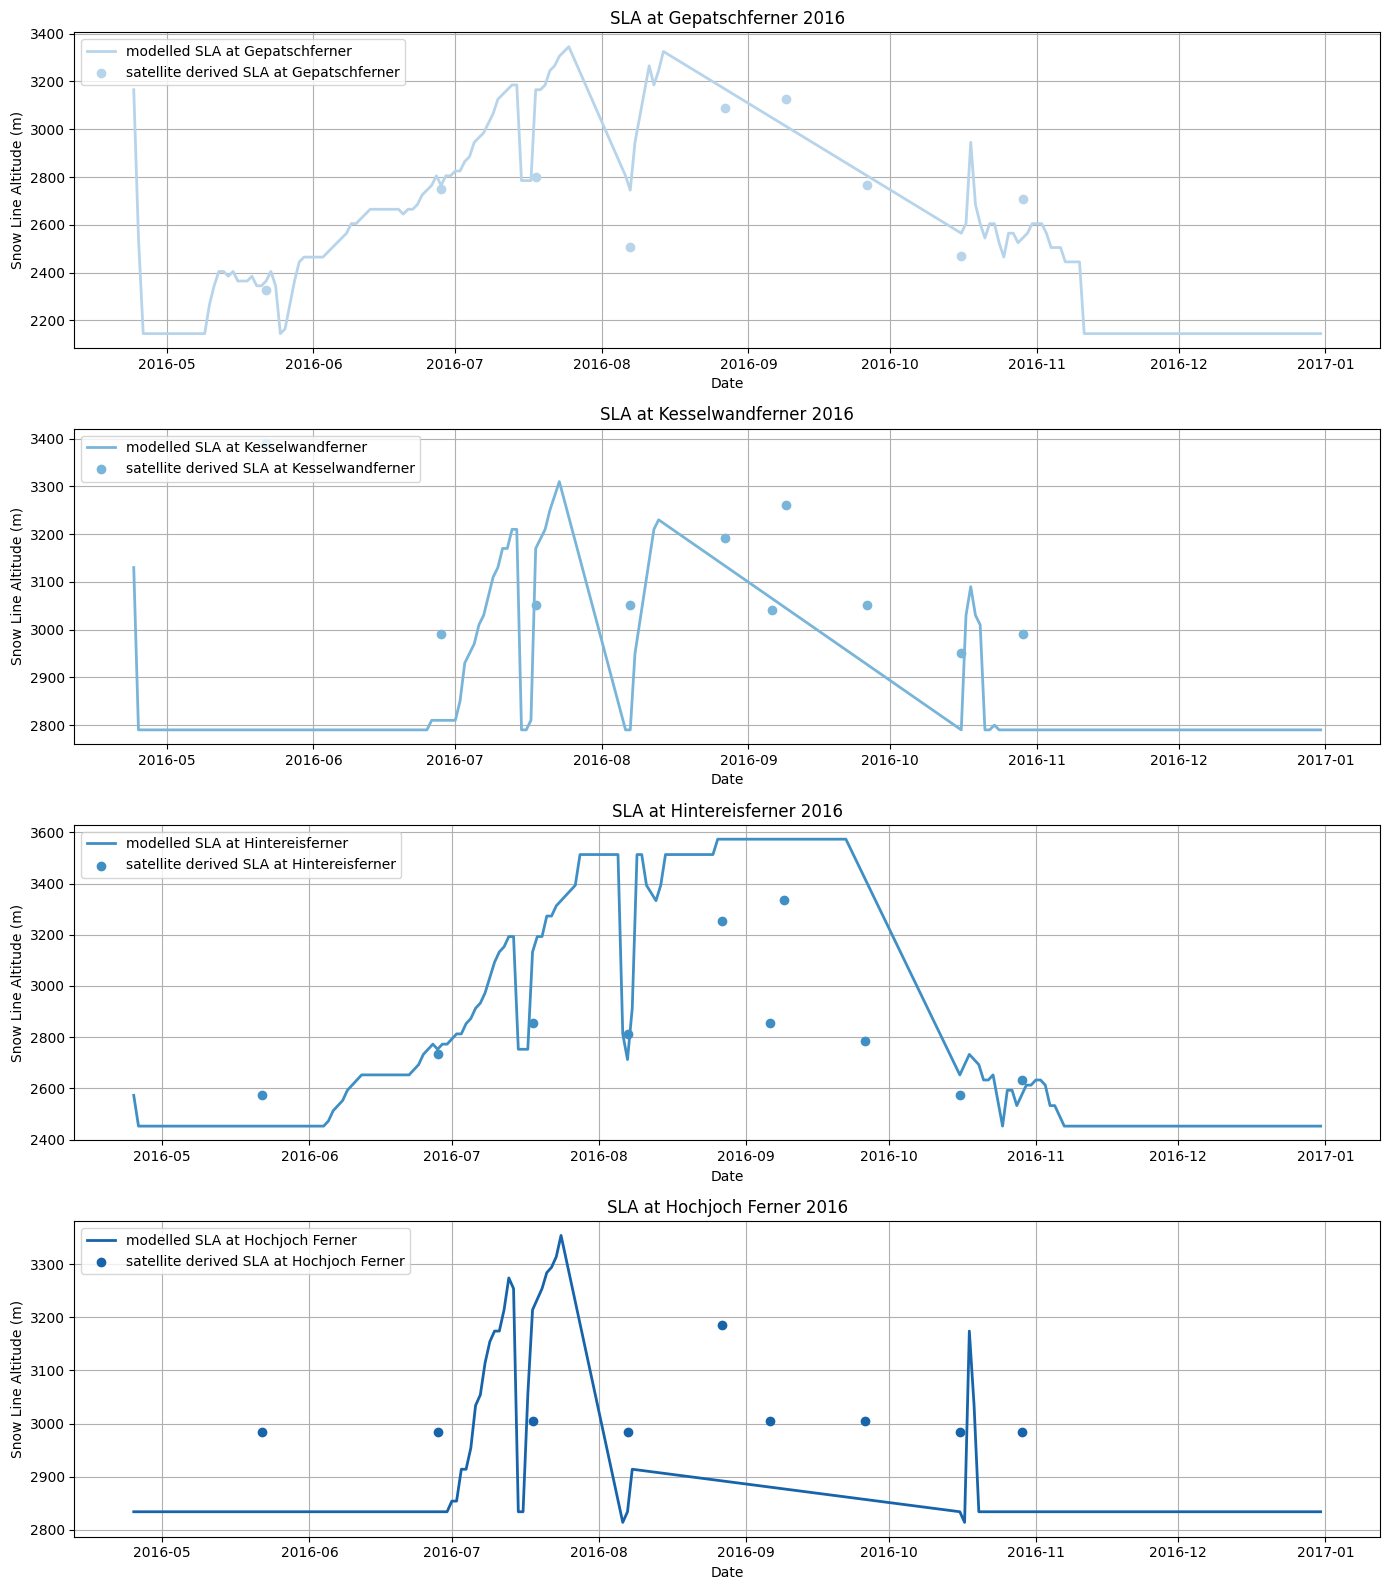

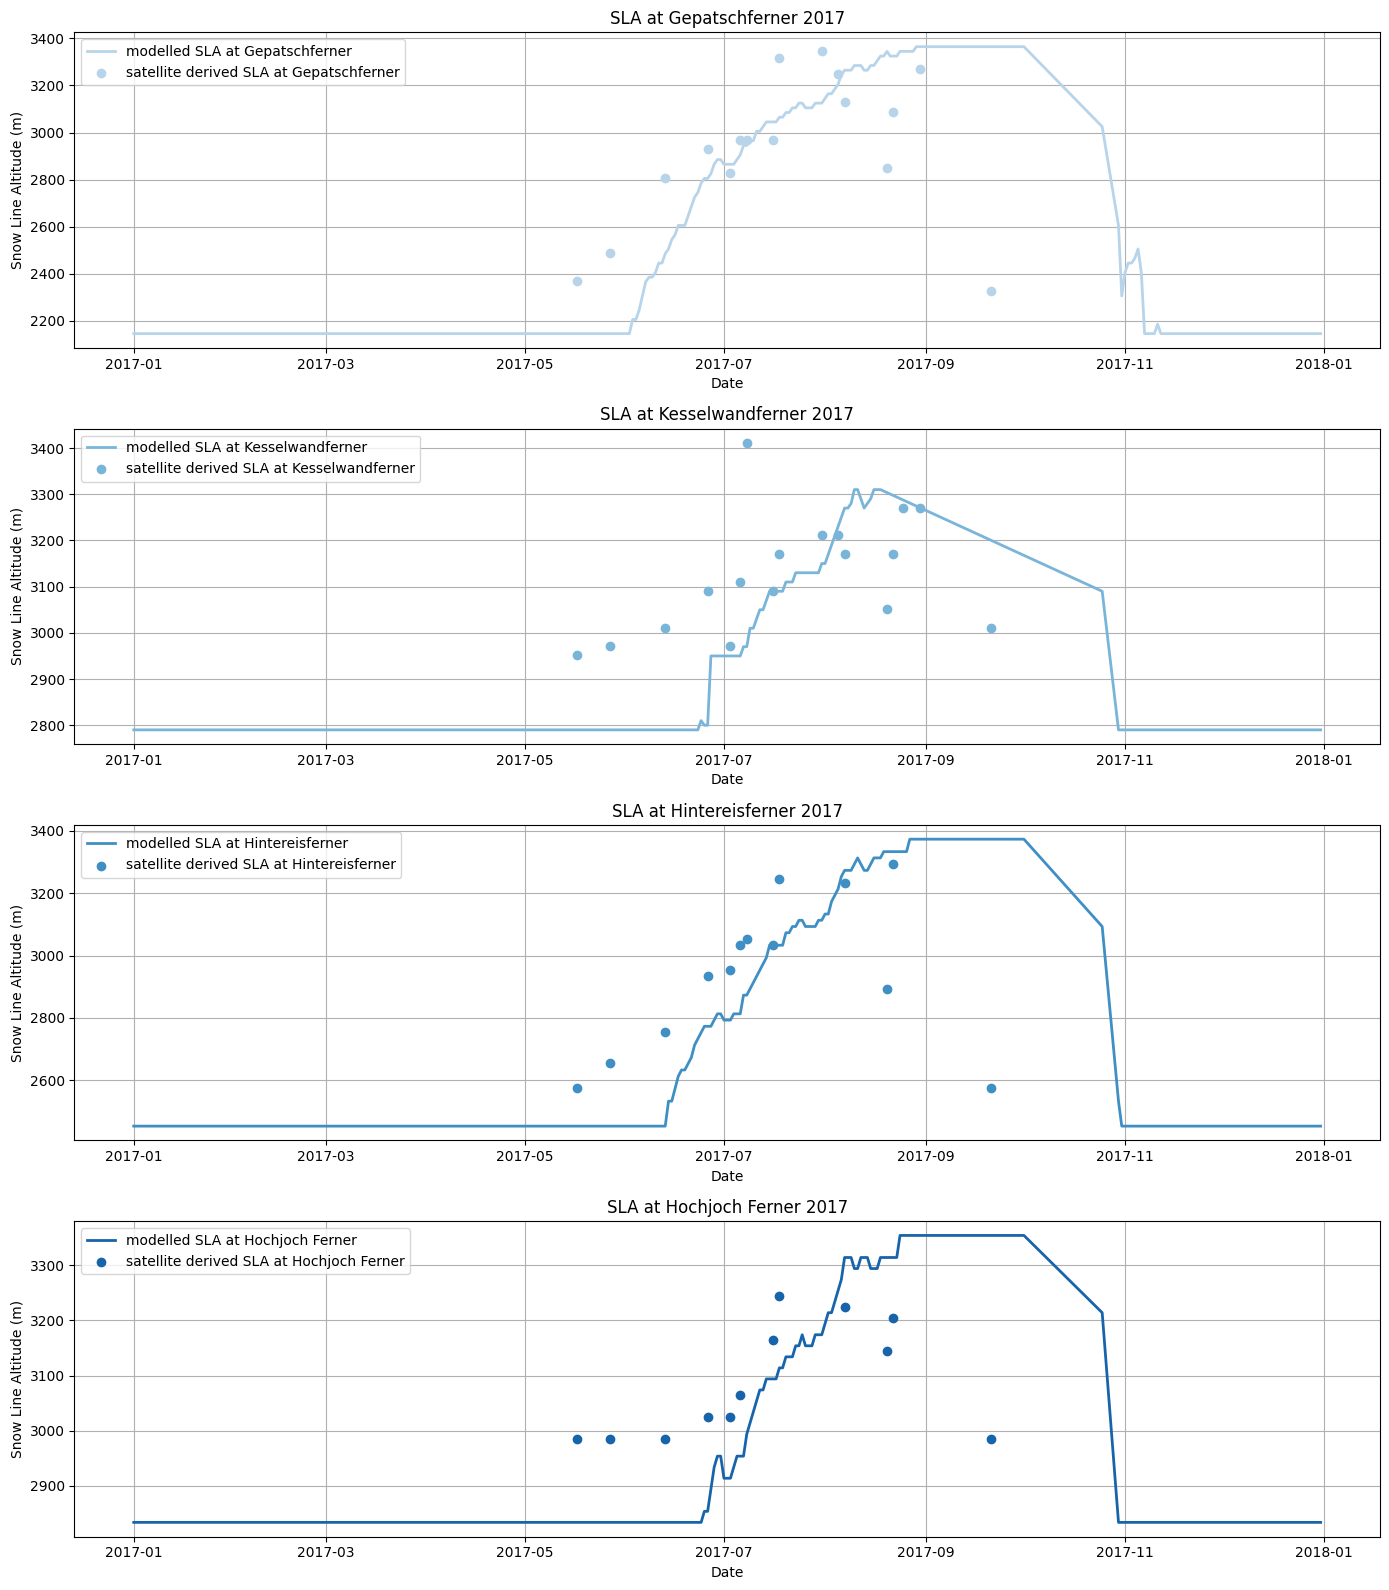

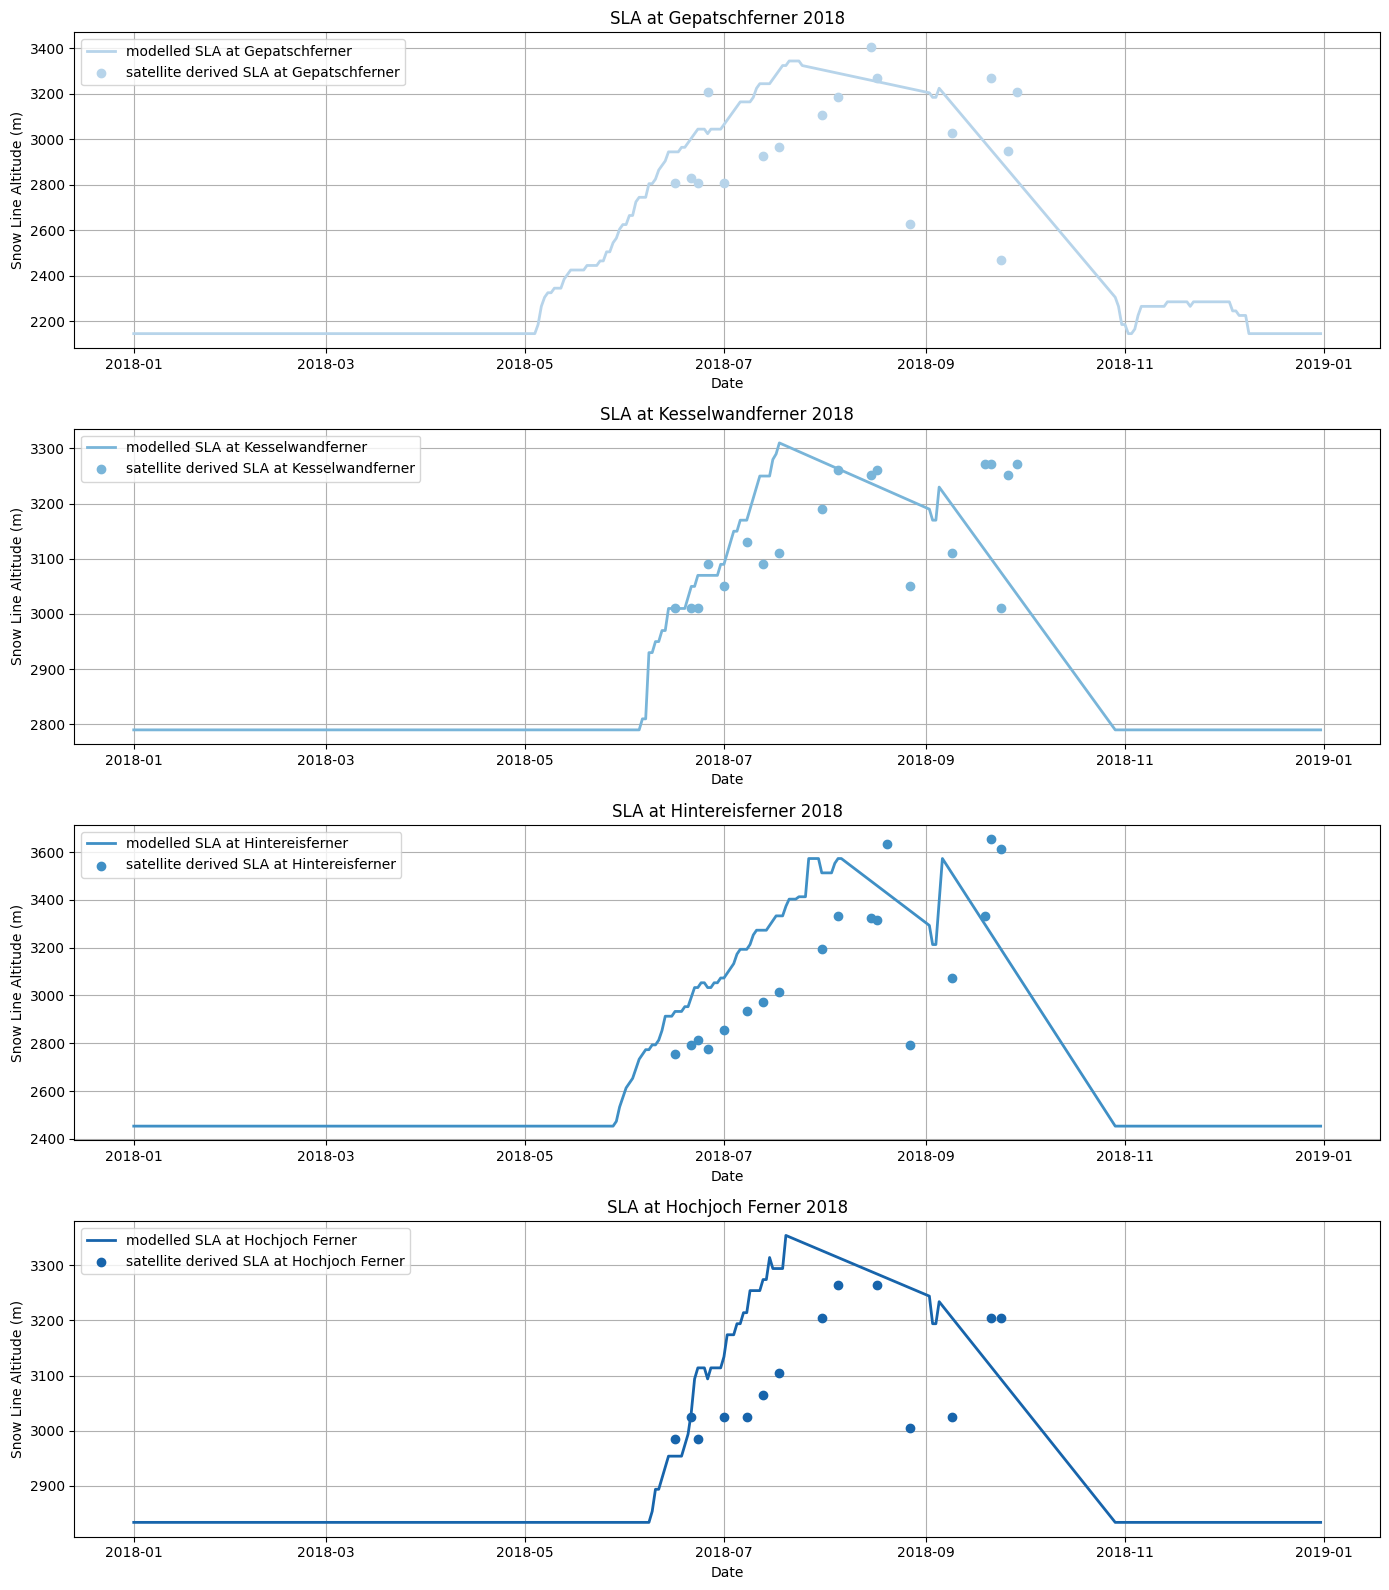

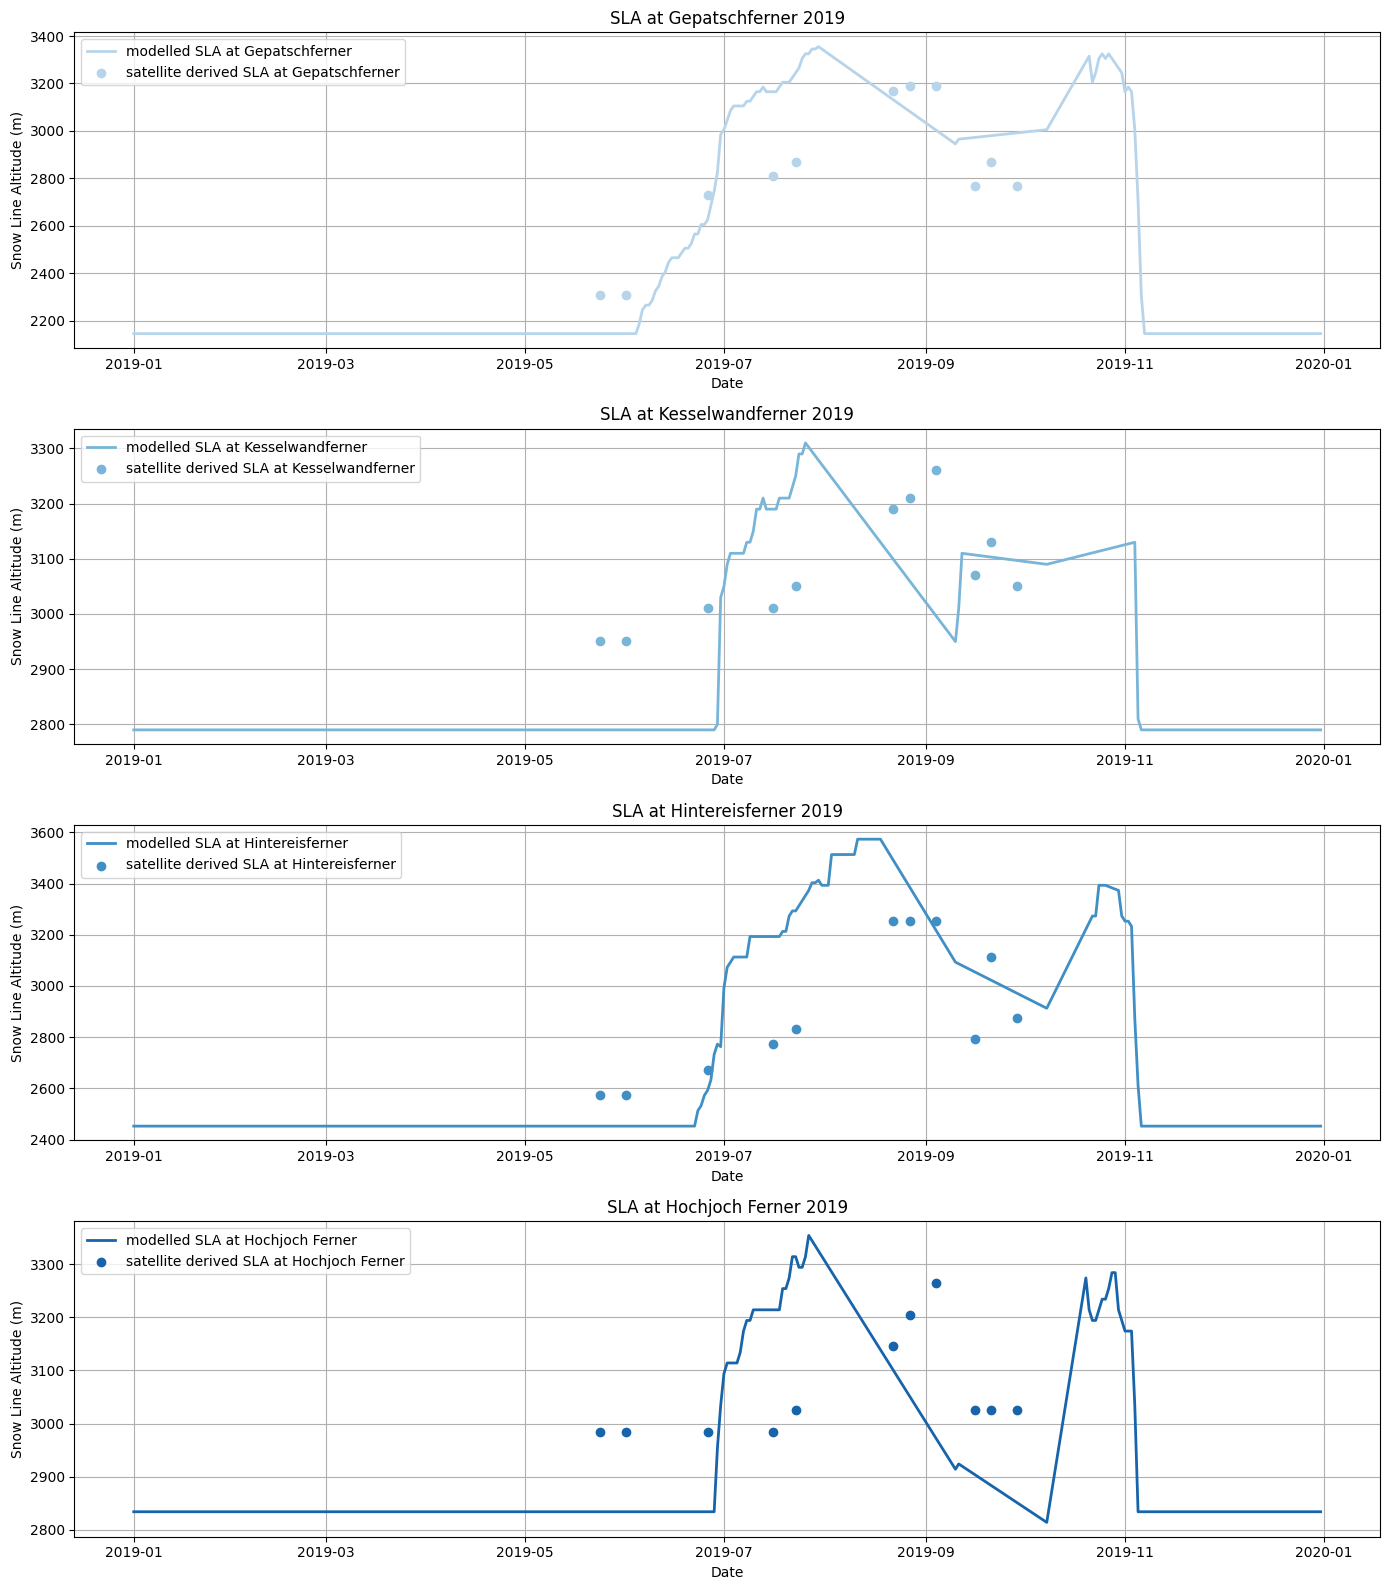

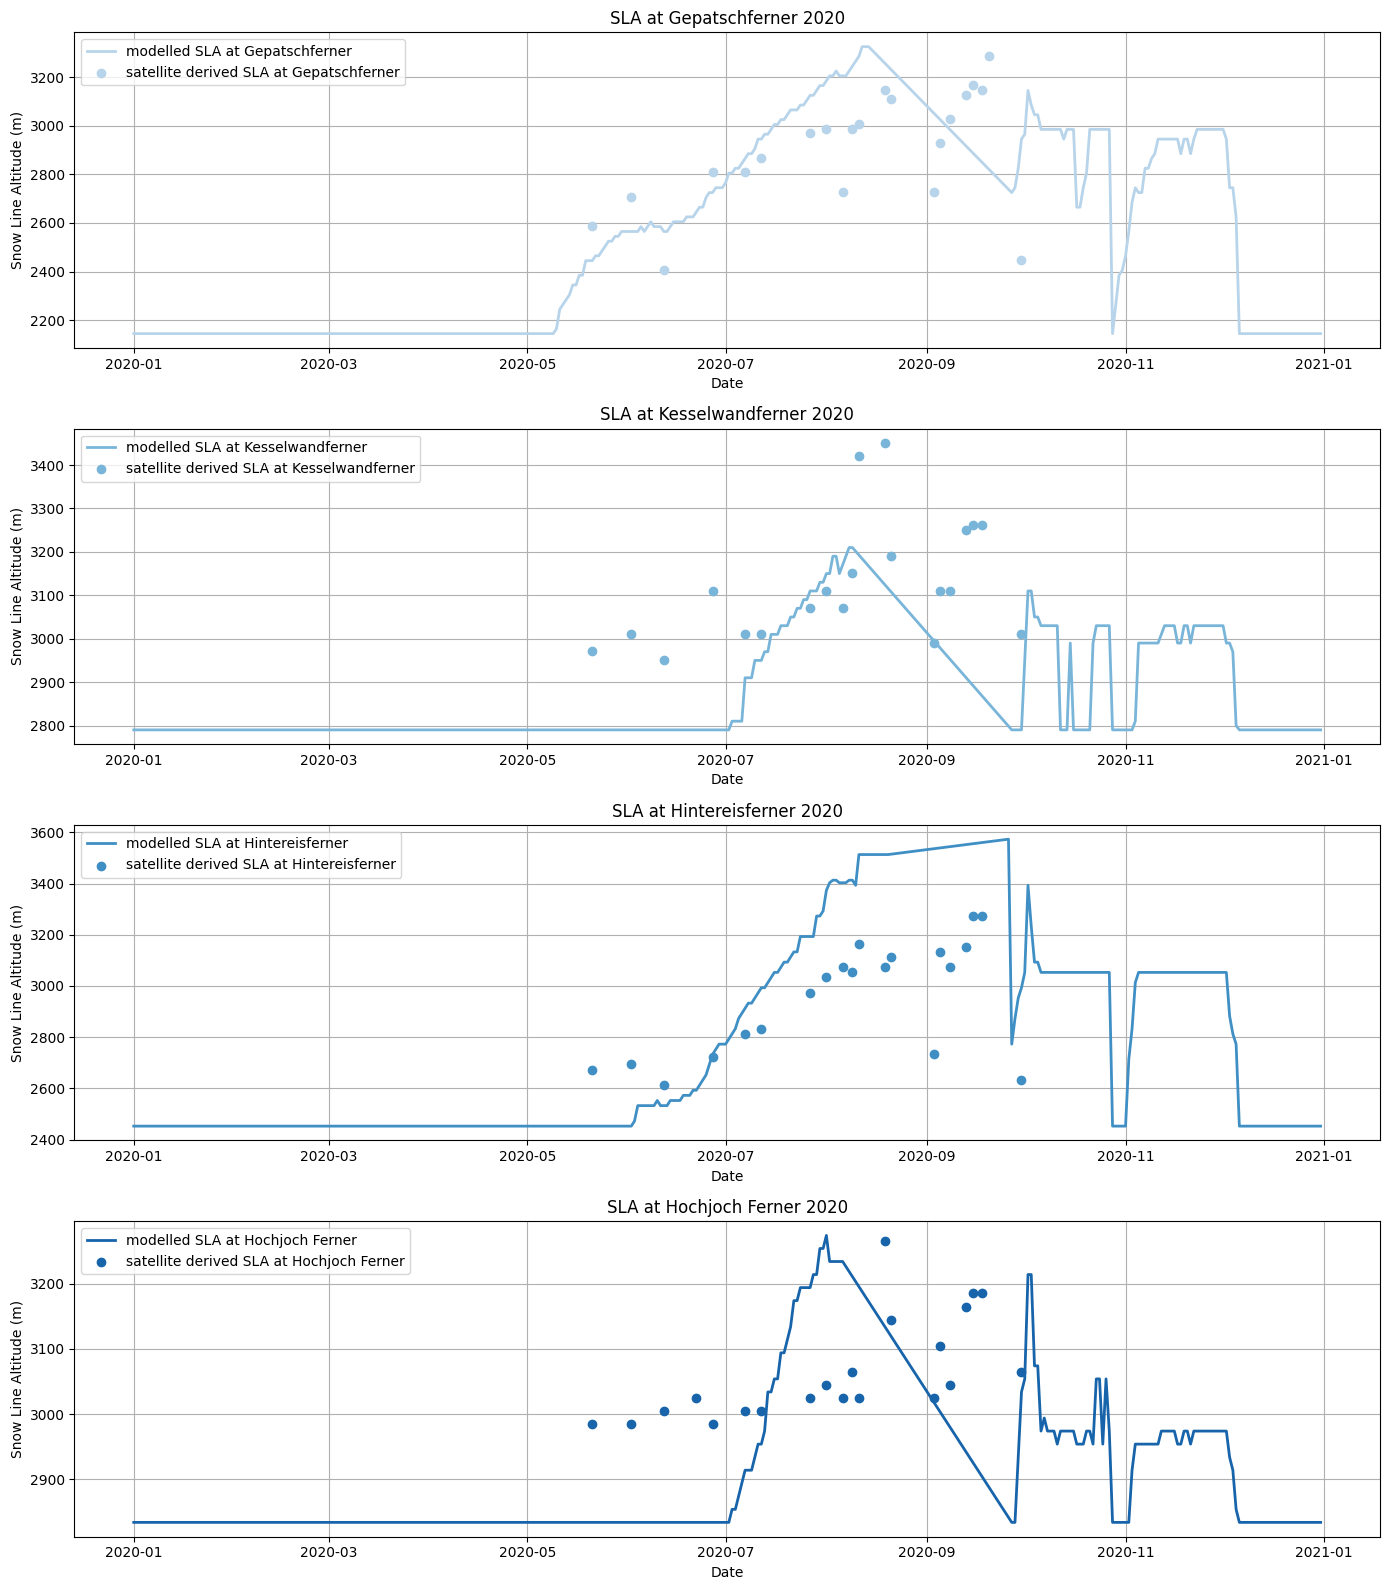

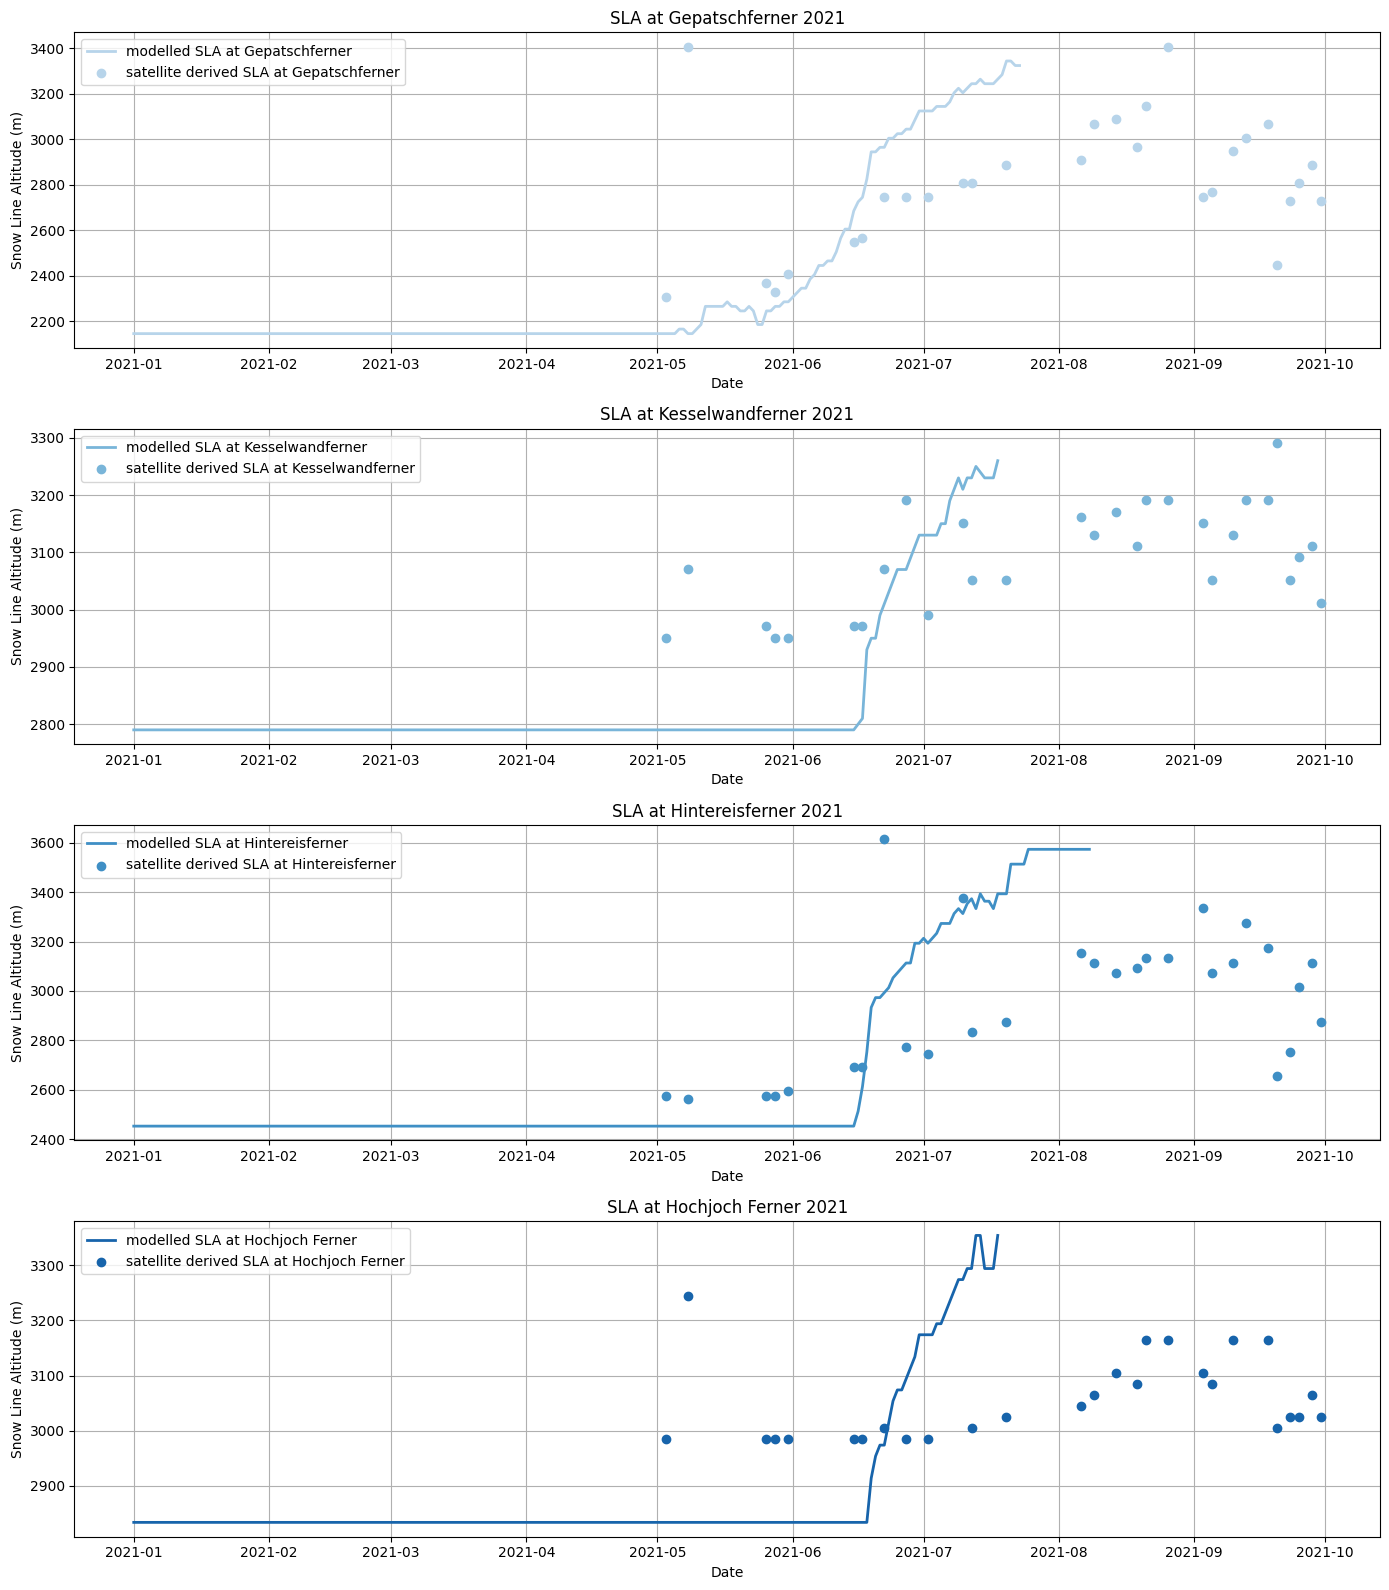

In [5]:
#Joined SLA Plot für einzelne Jahre
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# -------------------------------
# 1) Parameter: Pfade & Gletscher-IDs
# -------------------------------
input_folder_continuous = r"C:/Users/anne_/Desktop/Anne/SC_Rasters2016-21"  # Ordner mit kontinuierlichen CSVs
input_folder_discontinuous = r"C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv"  # Ordner mit diskontinuierlichen CSVs

# Gletscher-IDs und zugehörige Namen:
gid_to_name = {
    755530: "Gepatschferner",
    755560: "Kesselwandferner",
    755531: "Hintereisferner",
    755612: "Hochjoch Ferner"
}
gids = list(gid_to_name.keys())

# -------------------------------
# 2) Farben definieren
# -------------------------------
num_glaciers = len(gids)
blues = cm.Blues(np.linspace(0.3, 0.8, num_glaciers))  # 4 Blautöne von hell bis dunkel

# -------------------------------
# 3) Subplots erstellen und für jedes Jahr iterieren
# -------------------------------
years = range(2016, 2022)  # Jahre 2016 bis 2021

for year in years:
    output_path = f"C:/Users/anne_/Desktop/Anne/split_SLA_{year}.png"  # Speicherpfad für das Jahr
    fig, axs = plt.subplots(num_glaciers, 1, figsize=(14, 4 * num_glaciers))  # Breite angepasst, Höhe reduziert

    # Wenn nur ein Gletscher vorhanden ist, wird axs zu einem einzelnen Ax-Objekt, daher müssen wir es in eine Liste umwandeln.
    if num_glaciers == 1:
        axs = [axs]

    # Iteriere über alle Gletscher
    for i, gid in enumerate(gids):
        # ------------------------------
        # 1) Einlesen der kontinuierlichen SLA-Daten
        # ------------------------------
        csv_file_continuous = os.path.join(input_folder_continuous, f"snowline_results_{gid}.csv")

        # CSV einlesen
        df_continuous = pd.read_csv(csv_file_continuous)

        # Zeilen mit "No SLA found" ausschließen
        df_continuous = df_continuous[df_continuous["SLA Range (m)"] != "No SLA found"]
        if df_continuous.empty:
            print(f"Keine gültigen kontinuierlichen SLA-Daten für Gletscher {gid} in '{csv_file_continuous}'.")
            continue

        # SLA-Min / -Max extrahieren
        df_continuous["SLA_min"] = df_continuous["SLA Range (m)"].str.split(" - ").str[0].astype(float)
        df_continuous["SLA_max"] = df_continuous["SLA Range (m)"].str.split(" - ").str[1].astype(float)
        df_continuous["SLA_mid"] = (df_continuous["SLA_min"] + df_continuous["SLA_max"]) / 2

        # Datum parsen (Format: YYYYMMDD)
        df_continuous["Date"] = pd.to_datetime(df_continuous["Date"], format="%Y%m%d")

        # Die kontinuierlichen Daten für das aktuelle Jahr filtern
        df_continuous = df_continuous[df_continuous["Date"].dt.year == year]

        # Sortierung nach Datum
        df_continuous.sort_values(by="Date", inplace=True)

        # ------------------------------
        # 2) Einlesen der diskontinuierlichen SLA-Daten
        # ------------------------------
        csv_file_discontinuous = os.path.join(input_folder_discontinuous, f"snowline_results_{gid}.csv")

        # CSV einlesen
        df_discontinuous = pd.read_csv(csv_file_discontinuous)

        # Zeilen mit "No SLA found" ausschließen
        df_discontinuous = df_discontinuous[df_discontinuous["SLA Range (m)"] != "No SLA found"]
        if df_discontinuous.empty:
            print(f"Keine gültigen diskontinuierlichen SLA-Daten für Gletscher {gid} in '{csv_file_discontinuous}'.")
            continue

        # SLA-Min / -Max extrahieren
        df_discontinuous["SLA_min"] = df_discontinuous["SLA Range (m)"].str.split(" - ").str[0].astype(float)
        df_discontinuous["SLA_max"] = df_discontinuous["SLA Range (m)"].str.split(" - ").str[1].astype(float)
        df_discontinuous["SLA_mid"] = (df_discontinuous["SLA_min"] + df_discontinuous["SLA_max"]) / 2

        # Datum parsen (Format: YYYYMMDD)
        df_discontinuous["Date"] = pd.to_datetime(df_discontinuous["Date"], format="%Y%m%d")

        # Die diskontinuierlichen Daten für das aktuelle Jahr filtern
        df_discontinuous = df_discontinuous[df_discontinuous["Date"].dt.year == year]

        # Sortierung nach Datum
        df_discontinuous.sort_values(by="Date", inplace=True)

        # ------------------------------
        # 3) Plotten der kontinuierlichen SLA-Daten
        # ------------------------------
        axs[i].plot(
            df_continuous["Date"], 
            df_continuous["SLA_mid"],
            color=blues[i],
            linestyle="-",
            linewidth=2,
            marker=None,
            label=f"modelled SLA at {gid_to_name[gid]}"  # Statt Gletscher-ID den Namen anzeigen
        )

        # ------------------------------
        # 4) Plotten der diskontinuierlichen SLA-Daten als Punkte
        # ------------------------------
        axs[i].scatter(
            df_discontinuous["Date"], 
            df_discontinuous["SLA_mid"],
            color=blues[i], 
            label=f"satellite derived SLA at {gid_to_name[gid]}", 
            zorder=5  # Damit die Punkte über der Linie sind
        )

        # Details für jedes Subplot
        axs[i].set_xlabel("Date")
        axs[i].set_ylabel("Snow Line Altitude (m)")
        axs[i].set_title(f"SLA at {gid_to_name[gid]} {year}")
        axs[i].grid(True)
        
        # Position der Legende anpassen (links oben)
        axs[i].legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=10)

    # -------------------------------
    # 5) Diagramm anpassen & Speichern
    # -------------------------------
    plt.tight_layout()  # Verhindert, dass die Subplots überlappen

    # Grafik speichern (z. B. als PNG in hoher Auflösung)
    plt.savefig(output_path, dpi=300)

    # Optional: Plot anzeigen
    plt.show()


          Gletscher  Mean Difference  Standard Deviation Difference  \
0    Gepatschferner        88.525424                     311.933976   
1  Kesselwandferner       -84.518519                     165.234623   
2   Hintereisferner        96.741935                     269.799071   
3   Hochjoch Ferner       -21.769231                     172.613659   

   Variance Difference  Mean Continuous  Std Continuous  Var Continuous  \
0         97302.805377      2430.937500      408.764971   167088.801595   
1         27302.480783      2844.792627      125.242084    15685.579498   
2         72791.538868      2670.028640      355.466817   126356.658284   
3         29795.475113      2900.080051      144.231559    20802.742475   

   Mean Discontinuous  Std Discontinuous  Var Discontinuous  
0         2870.718447         282.312559       79700.380735  
1         3111.471698         116.016272       13459.775382  
2         2965.188119         273.840418       74988.574257  
3         3064.14893

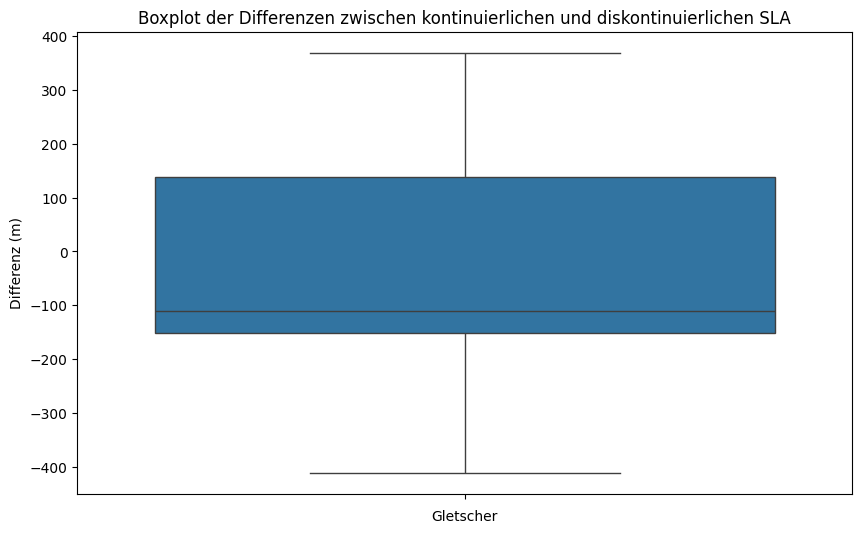

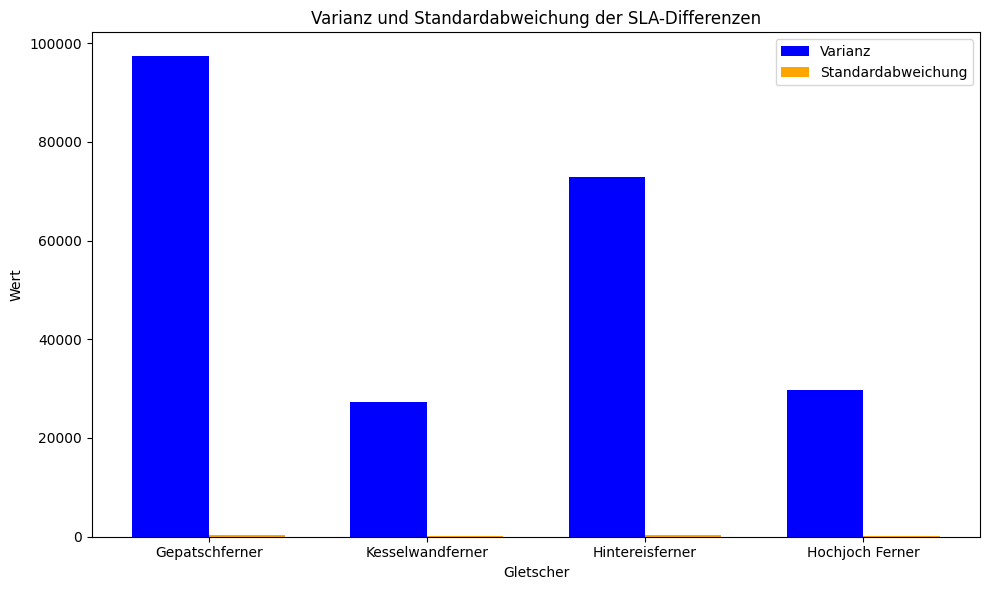

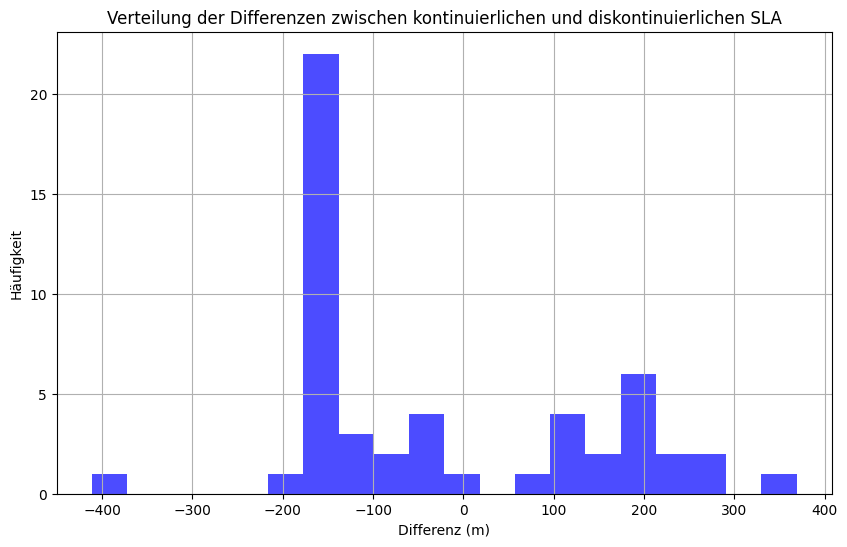

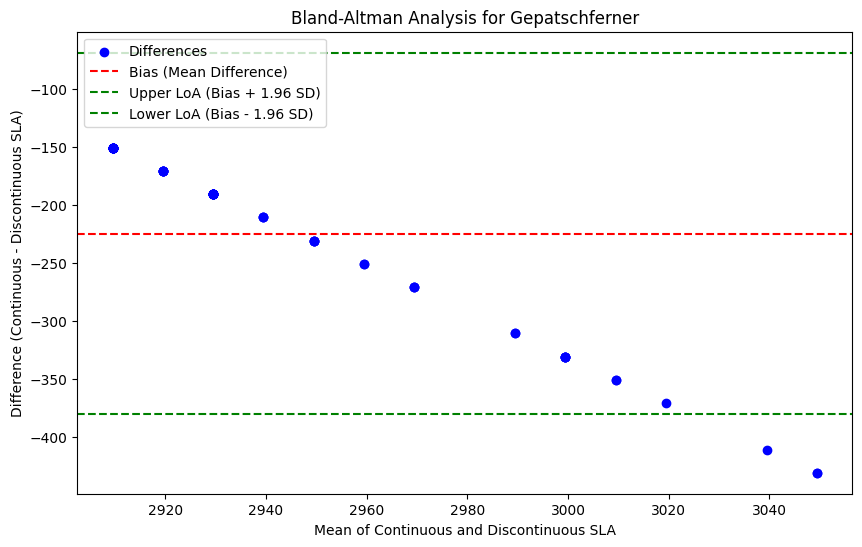

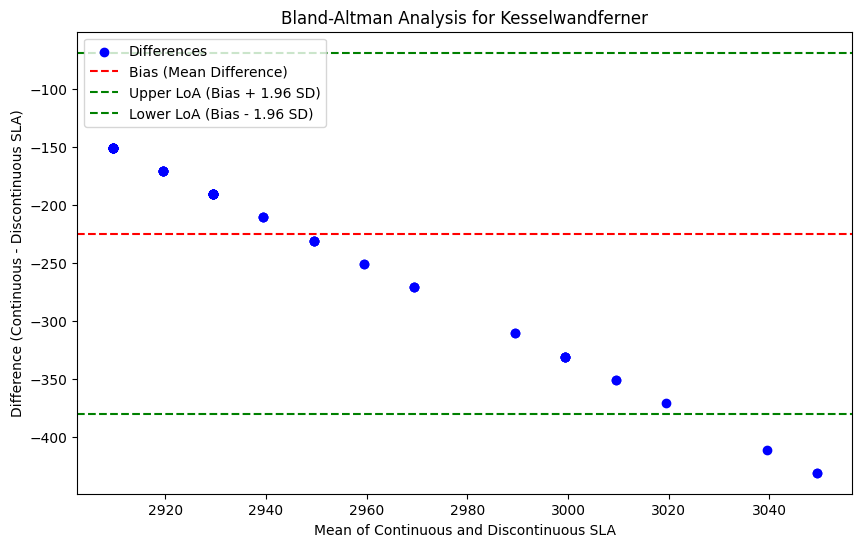

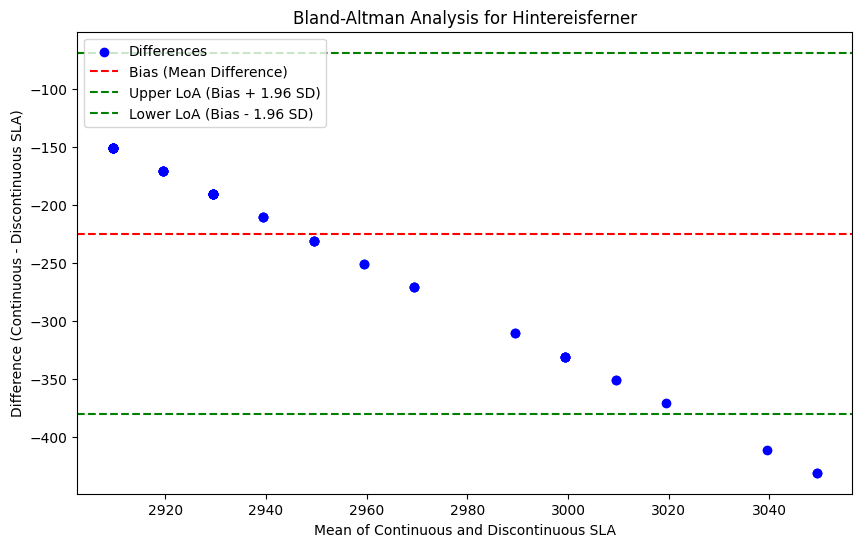

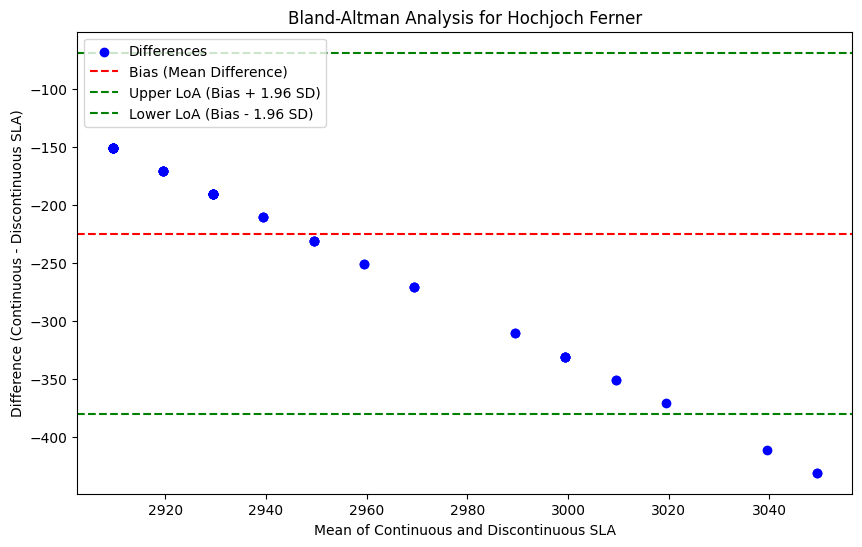

In [11]:
# Statistische Analyse
# Differenzanalyse und Varianz/Standardabweichung
# Der Code gibt ein DataFrame mit den berechneten Mittelwerten, der Standardabweichung und der Varianz für beide Datensätze (kontinuierlich und diskontinuierlich) sowie die Differenzen zwischen diesen beiden aus.
# Der Code speichert die Ergebnisse in einer CSV-Datei, die du weiter analysieren kannst.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pfade zu den CSV-Dateien (kontinuierlich und diskontinuierlich)
input_folder_continuous = r"C:/Users/anne_/Desktop/Anne/SC_Rasters2016-21"  # Ordner mit kontinuierlichen CSVs
input_folder_discontinuous = r"C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv"  # Ordner mit diskontinuierlichen CSVs

# Gletscher-IDs und zugehörige Namen
gid_to_name = {
    755530: "Gepatschferner",
    755560: "Kesselwandferner",
    755531: "Hintereisferner",
    755612: "Hochjoch Ferner"
}
gids = list(gid_to_name.keys())

# Initialisieren von Listen zur Speicherung der Ergebnisse
mean_diff_list = []
std_diff_list = []
var_diff_list = []

mean_continuous_list = []
std_continuous_list = []
var_continuous_list = []

mean_discontinuous_list = []
std_discontinuous_list = []
var_discontinuous_list = []

# Iteriere über alle Gletscher
for i, gid in enumerate(gids):
    # 1. Einlesen der kontinuierlichen SLA-Daten
    csv_file_continuous = os.path.join(input_folder_continuous, f"snowline_results_{gid}.csv")
    df_continuous = pd.read_csv(csv_file_continuous)

    # Zeilen mit "No SLA found" ausschließen
    df_continuous = df_continuous[df_continuous["SLA Range (m)"] != "No SLA found"]
    if df_continuous.empty:
        print(f"Keine gültigen kontinuierlichen SLA-Daten für Gletscher {gid} in '{csv_file_continuous}'.")
        continue

    # SLA-Min / -Max extrahieren und mittlere SLA berechnen
    df_continuous["SLA_min"] = df_continuous["SLA Range (m)"].str.split(" - ").str[0].astype(float)
    df_continuous["SLA_max"] = df_continuous["SLA Range (m)"].str.split(" - ").str[1].astype(float)
    df_continuous["SLA_mid"] = (df_continuous["SLA_min"] + df_continuous["SLA_max"]) / 2

    # Datum parsen (Format: YYYYMMDD)
    df_continuous["Date"] = pd.to_datetime(df_continuous["Date"], format="%Y%m%d")

    # 2. Einlesen der diskontinuierlichen SLA-Daten
    csv_file_discontinuous = os.path.join(input_folder_discontinuous, f"snowline_results_{gid}.csv")
    df_discontinuous = pd.read_csv(csv_file_discontinuous)

    # Zeilen mit "No SLA found" ausschließen
    df_discontinuous = df_discontinuous[df_discontinuous["SLA Range (m)"] != "No SLA found"]
    if df_discontinuous.empty:
        print(f"Keine gültigen diskontinuierlichen SLA-Daten für Gletscher {gid} in '{csv_file_discontinuous}'.")
        continue

    # SLA-Min / -Max extrahieren und mittlere SLA berechnen
    df_discontinuous["SLA_min"] = df_discontinuous["SLA Range (m)"].str.split(" - ").str[0].astype(float)
    df_discontinuous["SLA_max"] = df_discontinuous["SLA Range (m)"].str.split(" - ").str[1].astype(float)
    df_discontinuous["SLA_mid"] = (df_discontinuous["SLA_min"] + df_discontinuous["SLA_max"]) / 2

    # Datum parsen (Format: YYYYMMDD)
    df_discontinuous["Date"] = pd.to_datetime(df_discontinuous["Date"], format="%Y%m%d")

    # Die diskontinuierlichen Daten ab 2016 filtern
    df_discontinuous = df_discontinuous[df_discontinuous["Date"] >= "2016-01-01"]

    # 3. Differenzenanalyse (Mean Difference)
    # Berechne Differenzen zwischen kontinuierlichen und diskontinuierlichen Daten
    merged_df = pd.merge(df_continuous[["Date", "SLA_mid"]], df_discontinuous[["Date", "SLA_mid"]], on="Date", suffixes=('_continuous', '_discontinuous'))
    differences = merged_df["SLA_mid_continuous"] - merged_df["SLA_mid_discontinuous"]

    # Berechne den Mittelwert der Differenzen
    mean_diff = differences.mean()
    mean_diff_list.append(mean_diff)

    # Berechne die Standardabweichung und Varianz der Differenzen
    std_diff = differences.std()
    var_diff = differences.var()
    std_diff_list.append(std_diff)
    var_diff_list.append(var_diff)

    # Berechne den Mittelwert, die Standardabweichung und die Varianz für die kontinuierlichen und diskontinuierlichen Daten
    mean_continuous = df_continuous["SLA_mid"].mean()
    std_continuous = df_continuous["SLA_mid"].std()
    var_continuous = df_continuous["SLA_mid"].var()

    mean_discontinuous = df_discontinuous["SLA_mid"].mean()
    std_discontinuous = df_discontinuous["SLA_mid"].std()
    var_discontinuous = df_discontinuous["SLA_mid"].var()

    # Speichern der Ergebnisse
    mean_continuous_list.append(mean_continuous)
    std_continuous_list.append(std_continuous)
    var_continuous_list.append(var_continuous)

    mean_discontinuous_list.append(mean_discontinuous)
    std_discontinuous_list.append(std_discontinuous)
    var_discontinuous_list.append(var_discontinuous)

# Zusammenfassen der Ergebnisse in einem DataFrame
results_df = pd.DataFrame({
    "Gletscher": [gid_to_name[gid] for gid in gids],
    "Mean Difference": mean_diff_list,
    "Standard Deviation Difference": std_diff_list,
    "Variance Difference": var_diff_list,
    "Mean Continuous": mean_continuous_list,
    "Std Continuous": std_continuous_list,
    "Var Continuous": var_continuous_list,
    "Mean Discontinuous": mean_discontinuous_list,
    "Std Discontinuous": std_discontinuous_list,
    "Var Discontinuous": var_discontinuous_list
})

# Ausgabe der Ergebnisse
print(results_df)

# Optional: Speichern der Ergebnisse in einer CSV-Datei
output_results_path = r"C:/Users/anne_/Desktop/Anne/SLA_Analysis_Results.csv"
results_df.to_csv(output_results_path, index=False)

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Visualisierung der Differenzen (Boxplot)
# -------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(data=differences)  # 'differences' enthält die Differenzen
plt.title('Boxplot der Differenzen zwischen kontinuierlichen und diskontinuierlichen SLA')
plt.xlabel('Gletscher')
plt.ylabel('Differenz (m)')
plt.show()

# -------------------------------
# Visualisierung der Varianz und Standardabweichung (Balkendiagramm)
# -------------------------------
# Berechne die Varianz und Standardabweichung
variances = np.array(var_diff_list)  # Varianz für jeden Gletscher
std_devs = np.array(std_diff_list)   # Standardabweichung für jeden Gletscher

# Erstelle ein Balkendiagramm für die Varianz und Standardabweichung
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35  # Breite der Balken
index = np.arange(len(gids))  # Positionen für die Balken (für Gletscher)

bar1 = ax.bar(index, variances, bar_width, label='Varianz', color='blue')
bar2 = ax.bar(index + bar_width, std_devs, bar_width, label='Standardabweichung', color='orange')

ax.set_xlabel('Gletscher')
ax.set_ylabel('Wert')
ax.set_title('Varianz und Standardabweichung der SLA-Differenzen')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([gid_to_name[gid] for gid in gids])
ax.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# Visualisierung der Verteilung der Differenzen (Histogramm)
# -------------------------------
plt.figure(figsize=(10, 6))
plt.hist(differences.to_numpy().flatten(), bins=20, color='blue', alpha=0.7)
plt.title('Verteilung der Differenzen zwischen kontinuierlichen und diskontinuierlichen SLA')
plt.xlabel('Differenz (m)')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.show()

# -------------------------------
# Visualisierung der Bland-Altman-Analyse
# -------------------------------
for i, gid in enumerate(gids):
    mean = (df_continuous["SLA_mid"] + df_discontinuous["SLA_mid"]) / 2
    differences = df_continuous["SLA_mid"] - df_discontinuous["SLA_mid"]

    bias = differences.mean()
    std_dev = differences.std()

    plt.figure(figsize=(10, 6))
    plt.scatter(mean, differences, color='blue', label='Differences')
    plt.axhline(bias, color='red', linestyle='--', label='Bias (Mean Difference)')
    plt.axhline(bias + 1.96 * std_dev, color='green', linestyle='--', label='Upper LoA (Bias + 1.96 SD)')
    plt.axhline(bias - 1.96 * std_dev, color='green', linestyle='--', label='Lower LoA (Bias - 1.96 SD)')

    plt.title(f'Bland-Altman Analysis for {gid_to_name[gid]}')
    plt.xlabel('Mean of Continuous and Discontinuous SLA')
    plt.ylabel('Difference (Continuous - Discontinuous SLA)')
    plt.legend(loc='upper left')
    plt.show()


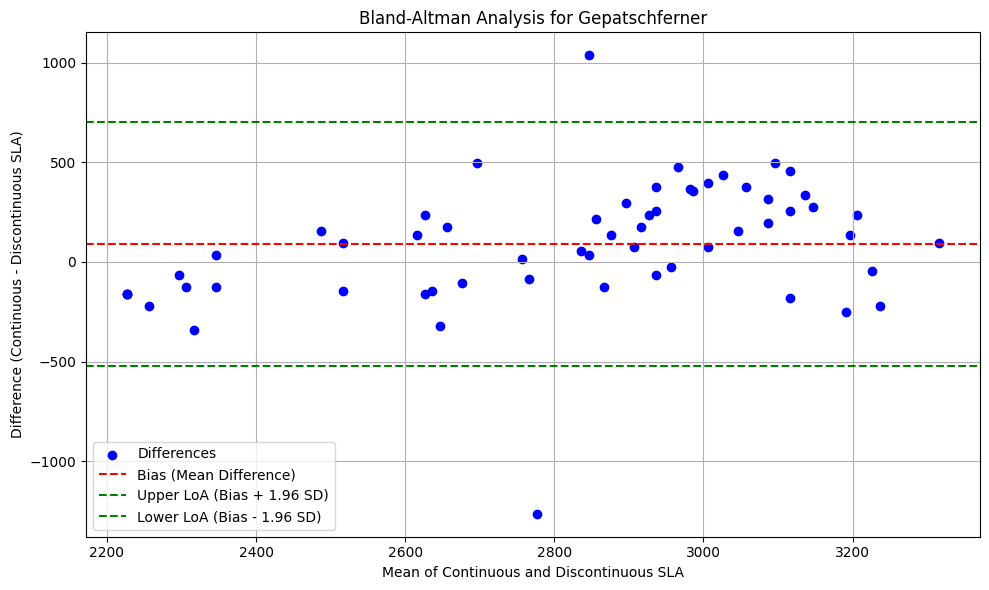

Bland-Altman-Plot für Gepatschferner gespeichert als C:/Users/anne_/Desktop/Anne/Bland_Altman_Gepatschferner.png


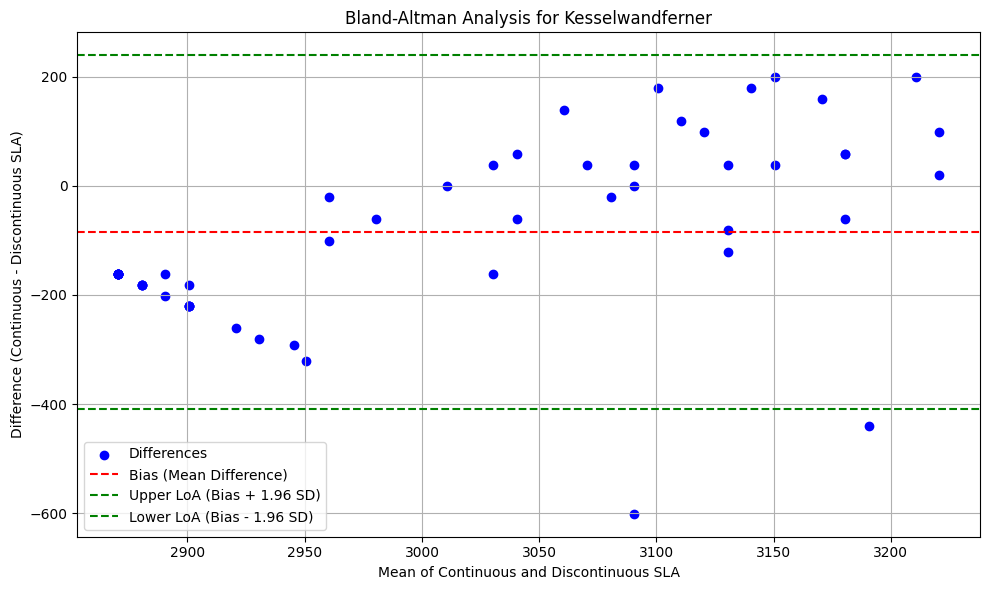

Bland-Altman-Plot für Kesselwandferner gespeichert als C:/Users/anne_/Desktop/Anne/Bland_Altman_Kesselwandferner.png


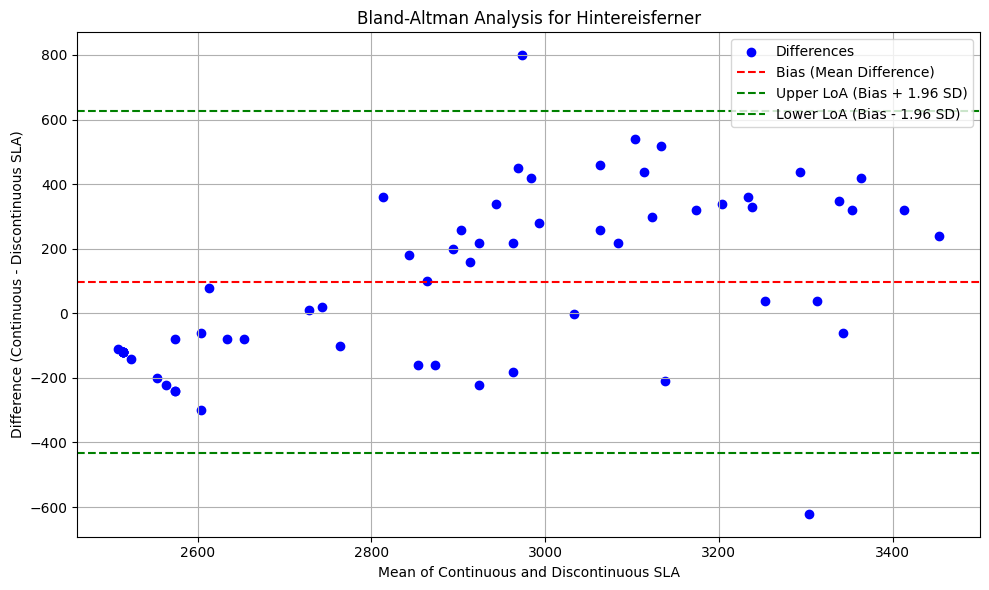

Bland-Altman-Plot für Hintereisferner gespeichert als C:/Users/anne_/Desktop/Anne/Bland_Altman_Hintereisferner.png


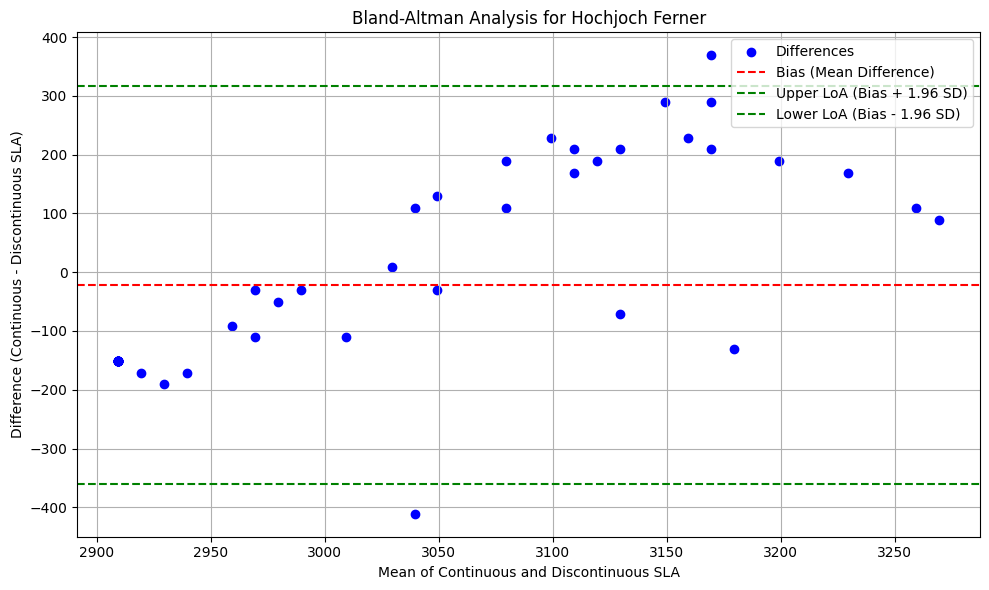

Bland-Altman-Plot für Hochjoch Ferner gespeichert als C:/Users/anne_/Desktop/Anne/Bland_Altman_Hochjoch Ferner.png


In [6]:
# Statistische Analyse

# Die Bland-Altman-Analyse ist eine ausgezeichnete Methode, um die Übereinstimmung zwischen zwei Messmethoden (in deinem Fall den kontinuierlichen und diskontinuierlichen SLA-Daten) zu beurteilen. Diese Methode untersucht, ob es systematische Unterschiede (Bias) gibt und wie groß die Streuung der Differenzen zwischen den beiden Methoden ist.
# Schritte für die Bland-Altman-Analyse:

#     Berechnung der Differenzen und Mittelwerte:
#         Differenz zwischen den kontinuierlichen und diskontinuierlichen SLA-Werten für jedes Paar.
#         Mittelwert der beiden Messmethoden (kontinuierlich und diskontinuierlich) für jedes Paar.

#     Berechnung des Bias:
#         Der Bias ist der Mittelwert der Differenzen (gibt an, ob eine der Methoden tendenziell höhere oder niedrigere Werte liefert).

#     Berechnung der Limits of Agreement (LoA):
#         Die Limits of Agreement werden als Mittelwert der Differenzen ± 1,96 mal die Standardabweichung der Differenzen berechnet. Diese geben den Bereich an, innerhalb dessen 95% der Differenzen liegen sollten.

#     Plot der Bland-Altman-Diagramme:
#         Ein Streudiagramm der Differenzen gegen den Mittelwert.
#         Zeichnen des Bias und der Limits of Agreement auf dem Diagramm.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pfade zu den CSV-Dateien (kontinuierlich und diskontinuierlich)
input_folder_continuous = r"C:/Users/anne_/Desktop/Anne/SC_Rasters2016-21"  # Ordner mit kontinuierlichen CSVs
input_folder_discontinuous = r"C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all SLA csv"  # Ordner mit diskontinuierlichen CSVs

# Gletscher-IDs und zugehörige Namen
gid_to_name = {
    755530: "Gepatschferner",
    755560: "Kesselwandferner",
    755531: "Hintereisferner",
    755612: "Hochjoch Ferner"
}
gids = list(gid_to_name.keys())

# Iteriere über alle Gletscher
for i, gid in enumerate(gids):
    # 1. Einlesen der kontinuierlichen SLA-Daten
    csv_file_continuous = os.path.join(input_folder_continuous, f"snowline_results_{gid}.csv")
    df_continuous = pd.read_csv(csv_file_continuous)

    # Zeilen mit "No SLA found" ausschließen
    df_continuous = df_continuous[df_continuous["SLA Range (m)"] != "No SLA found"]
    if df_continuous.empty:
        print(f"Keine gültigen kontinuierlichen SLA-Daten für Gletscher {gid} in '{csv_file_continuous}'.")
        continue

    # SLA-Min / -Max extrahieren und mittlere SLA berechnen
    df_continuous["SLA_min"] = df_continuous["SLA Range (m)"].str.split(" - ").str[0].astype(float)
    df_continuous["SLA_max"] = df_continuous["SLA Range (m)"].str.split(" - ").str[1].astype(float)
    df_continuous["SLA_mid"] = (df_continuous["SLA_min"] + df_continuous["SLA_max"]) / 2

    # Datum parsen (Format: YYYYMMDD)
    df_continuous["Date"] = pd.to_datetime(df_continuous["Date"], format="%Y%m%d")

    # 2. Einlesen der diskontinuierlichen SLA-Daten
    csv_file_discontinuous = os.path.join(input_folder_discontinuous, f"snowline_results_{gid}.csv")
    df_discontinuous = pd.read_csv(csv_file_discontinuous)

    # Zeilen mit "No SLA found" ausschließen
    df_discontinuous = df_discontinuous[df_discontinuous["SLA Range (m)"] != "No SLA found"]
    if df_discontinuous.empty:
        print(f"Keine gültigen diskontinuierlichen SLA-Daten für Gletscher {gid} in '{csv_file_discontinuous}'.")
        continue

    # SLA-Min / -Max extrahieren und mittlere SLA berechnen
    df_discontinuous["SLA_min"] = df_discontinuous["SLA Range (m)"].str.split(" - ").str[0].astype(float)
    df_discontinuous["SLA_max"] = df_discontinuous["SLA Range (m)"].str.split(" - ").str[1].astype(float)
    df_discontinuous["SLA_mid"] = (df_discontinuous["SLA_min"] + df_discontinuous["SLA_max"]) / 2

    # Datum parsen (Format: YYYYMMDD)
    df_discontinuous["Date"] = pd.to_datetime(df_discontinuous["Date"], format="%Y%m%d")

    # Die diskontinuierlichen Daten ab 2016 filtern
    df_discontinuous = df_discontinuous[df_discontinuous["Date"] >= "2016-01-01"]

    # 3. Differenzenanalyse (Bland-Altman-Analyse)
    # Berechne die Differenzen und den Mittelwert der beiden Datensätze
    merged_df = pd.merge(df_continuous[["Date", "SLA_mid"]], df_discontinuous[["Date", "SLA_mid"]], on="Date", suffixes=('_continuous', '_discontinuous'))
    differences = merged_df["SLA_mid_continuous"] - merged_df["SLA_mid_discontinuous"]
    means = (merged_df["SLA_mid_continuous"] + merged_df["SLA_mid_discontinuous"]) / 2

    # Berechnung des Bias (Mittelwert der Differenzen)
    bias = differences.mean()

    # Berechnung der Limits of Agreement (LoA)
    loa_upper = bias + 1.96 * differences.std()
    loa_lower = bias - 1.96 * differences.std()

    # 4. Bland-Altman-Plot erstellen
    plt.figure(figsize=(10, 6))
    plt.scatter(means, differences, color='blue', label='Differences')
    plt.axhline(bias, color='red', linestyle='--', label='Bias (Mean Difference)')
    plt.axhline(loa_upper, color='green', linestyle='--', label='Upper LoA (Bias + 1.96 SD)')
    plt.axhline(loa_lower, color='green', linestyle='--', label='Lower LoA (Bias - 1.96 SD)')
    plt.xlabel('Mean of Continuous and Discontinuous SLA')
    plt.ylabel('Difference (Continuous - Discontinuous SLA)')
    plt.title(f'Bland-Altman Analysis for {gid_to_name[gid]}')
    plt.legend()
    plt.grid(True)

    # Grafik speichern
    output_ba_path = f"C:/Users/anne_/Desktop/Anne/Bland_Altman_{gid_to_name[gid]}.png"
    plt.tight_layout()
    plt.savefig(output_ba_path, dpi=300)
    plt.show()
    
    print(f"Bland-Altman-Plot für {gid_to_name[gid]} gespeichert als {output_ba_path}")


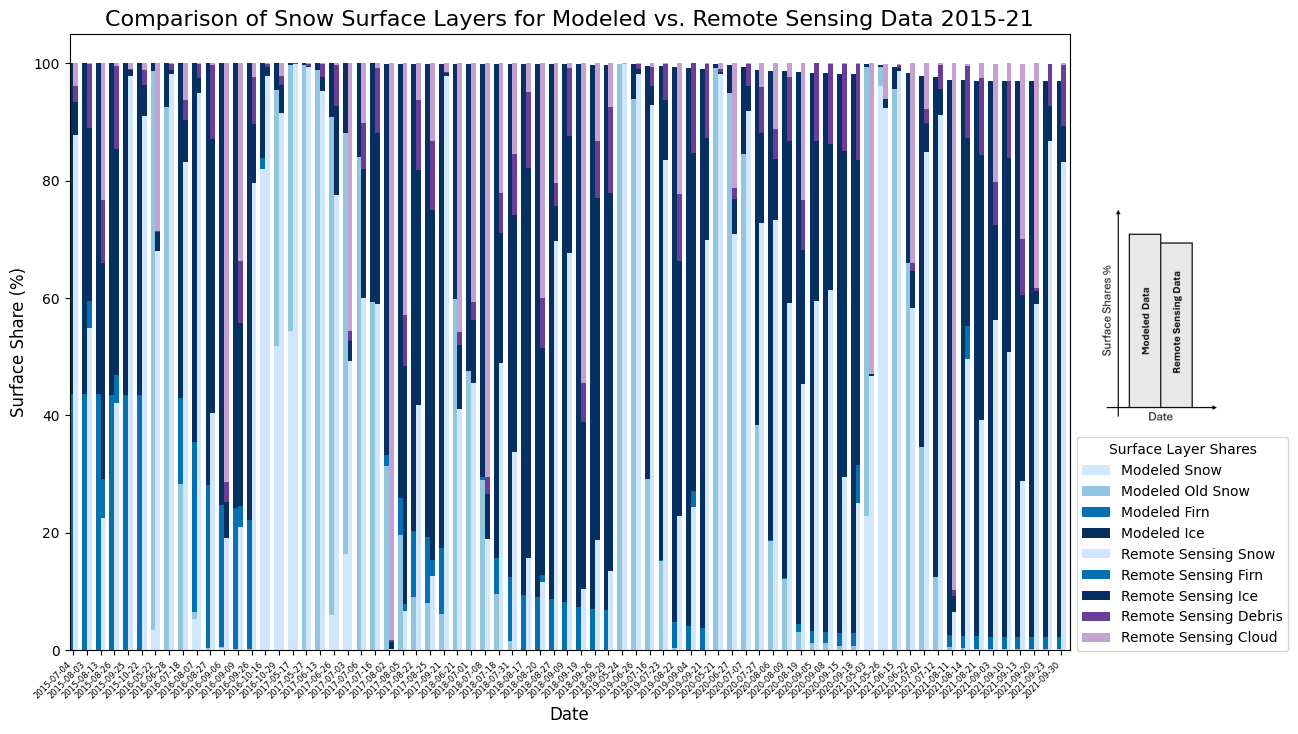

In [25]:
#Säulendiagramm zum vergleich der surface layer shares
import re
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# -------------------------------
# 1) Parameter: Pfade & Gletschermaske
# -------------------------------
input_folder_continuous = "C:/Users/anne_/Desktop/Anne/openamundsen-examples-main/openamundsen-examples-main/rofental/results_all_sa/output_grids.nc"  # Ordner mit kontinuierlichen NetCDF-Daten
input_folder_discontinuous = "C:/Users/anne_/Desktop/Anne/ENVEO/2015-21/all" #/2015/GLF_2015_T32TPS"  # Ordner mit diskontinuierlichen TIF-Daten
output_path = "C:/Users/anne_/Desktop/Anne/surface_shares_comparison2015-.png"  # Speicherpfad für die Grafik

# -------------------------------
# 2) Gletschermasken einlesen
# -------------------------------
mask_file_continuous = "C:/Users/anne_/Desktop/Anne/openamundsen-examples-main/openamundsen-examples-main/rofental/grids/OG ROI/all glacier extent/roi_rofental_50i.asc"  # Gletschermaske für 50m Auflösung
mask_file_discontinuous = "C:/Users/anne_/Desktop/Anne/ENVEO/glaciermask.tiff"  # Gletschermaske für 10m Auflösung

# Gletschermasken einlesen
with rasterio.open(mask_file_continuous) as src:
    glacier_mask_continuous = src.read(1)  # Gletschermaske für kontinuierliche Daten

with rasterio.open(mask_file_discontinuous) as src:
    glacier_mask_discontinuous = src.read(1)  # Gletschermaske für diskontinuierliche Daten

# -------------------------------
# 3) Tage der diskontinuierlichen Daten
# -------------------------------
# Suche nach den diskontinuierlichen Daten-Dateien im angegebenen Ordner
discontinuous_dates = []
for file in os.listdir(input_folder_discontinuous):
    if file.endswith(".tif"):
        match = re.search(r'GLF_S2A_MSIL1C_(\d{8})', file)
        if match:
            discontinuous_dates.append(match.group(1))

# -------------------------------
# 4) Initialisieren der Ergebnisse
# -------------------------------
results = []

# -------------------------------
# 5) Iteriere über die Tage mit diskontinuierlichen Daten
# -------------------------------
for date_str in discontinuous_dates:
    date = pd.to_datetime(date_str, format='%Y%m%d')

    # ------------------------------
    # 1) Einlesen der kontinuierlichen SLA-Daten aus der NetCDF-Datei
    # ------------------------------
    try:
        # Wähle den entsprechenden Zeitschritt aus der NetCDF-Datei
        nc_file = "C:/Users/anne_/Desktop/Anne/openamundsen-examples-main/openamundsen-examples-main/rofental/results_all_sa/output_grids.nc"  # Dein NetCDF-Dateipfad
        nc = xr.open_dataset(nc_file)
        
        # Wähle die entsprechenden Daten für das Ziel-Datum
        target_date = f"{date.strftime('%Y-%m-%d')}T21:00:00.000000000"
        snow_thickness = nc['snow_thickness_day'].sel(time2=target_date, method='nearest')
    
        # Initialisiere eine leere Matrix für die Oberflächenschichten
        surface_layer_continuous = np.zeros_like(glacier_mask_continuous, dtype=np.int32)
    
        # Iteriere über die Schichten und berechne die Flächenanteile
        for i in range(1, 5):  # Für die kontinuierlichen Daten (Layer 1-4)
            layer_index = i - 1
            layer_data = snow_thickness.isel(snow_layer=layer_index).values
    
            # Überprüfe, ob die Schicht relevant ist (d.h. Dicke > 0.2)
            if i == 1:  # Layer 1 (Schnee)
                mask = (glacier_mask_continuous == 1) & (layer_data > 0.2)  # Layer 1 wird zu Oberfläche, wenn keine Schicht darüber existiert
                surface_layer_continuous[mask] = 1
            elif i == 2:  # Layer 2 (Altschnee)
                mask = (glacier_mask_continuous == 1) & (layer_data > 0.2)  # Layer 2 wird nur berücksichtigt, wenn Layer 1 nicht überlappt
                surface_layer_continuous[mask & (surface_layer_continuous == 0)] = 2
            elif i == 3:  # Layer 3 (Firn)
                mask = (glacier_mask_continuous == 1) & (layer_data > 0.2)  # Layer 3 wird nur berücksichtigt, wenn Layer 1 und 2 nicht überlappt
                surface_layer_continuous[mask & (surface_layer_continuous == 0)] = 3
            elif i == 4:  # Layer 4 (Eis)
                mask = (glacier_mask_continuous == 1) & (layer_data > 0.2)  # Layer 4 wird nur berücksichtigt, wenn alle oberliegenden Layer keine Überlappung haben
                surface_layer_continuous[mask & (surface_layer_continuous == 0)] = 4
    
        # Berechne die Flächenanteile der Layer
        total_surface_area = np.sum(glacier_mask_continuous == 1)  # Gesamtfläche der Gletschermaske
        layer_1_area = np.sum(surface_layer_continuous == 1)
        layer_2_area = np.sum(surface_layer_continuous == 2)
        layer_3_area = np.sum(surface_layer_continuous == 3)
        layer_4_area = np.sum(surface_layer_continuous == 4)
    
        # Prozentuale Anteile berechnen
        layer_1_share = (layer_1_area / total_surface_area) * 100 if total_surface_area > 0 else 0
        layer_2_share = (layer_2_area / total_surface_area) * 100 if total_surface_area > 0 else 0
        layer_3_share = (layer_3_area / total_surface_area) * 100 if total_surface_area > 0 else 0
        layer_4_share = (layer_4_area / total_surface_area) * 100 if total_surface_area > 0 else 0

        # Ergebnisse speichern
        results.append({
            "Date": date.strftime("%Y-%m-%d"),
            "Modeled Snow": layer_1_share,
            "Modeled Old Snow": layer_2_share,
            "Modeled Firn": layer_3_share,
            "Modeled Ice": layer_4_share,
            "Modeled Debris": 0,  # Debris gibt es nicht bei den kontinuierlichen Daten
        })
    
    except Exception as e:
        print(f"Fehler bei {date}: {e}")

    # ------------------------------
    # 2) Einlesen der diskontinuierlichen SLA-Daten aus Rasterdateien (TIF)
    # ------------------------------
    try:
        # Suchen der Rasterdateien für das aktuelle Datum
        raster_files = [f for f in os.listdir(input_folder_discontinuous) if re.search(rf'{date_str}', f)]

        if raster_files:
            raster_file = raster_files[0]
            input_path = os.path.join(input_folder_discontinuous, raster_file)

            with rasterio.open(input_path) as src:
                band_data = src.read(1)  # Nur das erste Band einlesen

                # Initialisiere eine leere Matrix für die Oberflächenschichten
                surface_layer_discontinuous = np.zeros_like(glacier_mask_discontinuous, dtype=np.int32)

                # Iteriere über die Oberflächentypen (1 bis 5) und berechne die Flächenanteile
                for i in range(1, 6):  # Diskontinuierliche Daten (Schnee, Firn, Eis, Schutt, Wolken)
                    mask = (glacier_mask_discontinuous == 1) & (band_data == i)
                    surface_layer_discontinuous[mask] = i

                # Berechne die Flächenanteile
                total_area = np.sum(glacier_mask_discontinuous == 1)
                layer_1_area = np.sum(surface_layer_discontinuous == 1)
                layer_2_area = np.sum(surface_layer_discontinuous == 2)
                layer_3_area = np.sum(surface_layer_discontinuous == 3)
                layer_4_area = np.sum(surface_layer_discontinuous == 4)
                layer_5_area = np.sum(surface_layer_discontinuous == 5)

                # Prozentsätze berechnen
                layer_1_percentage = (layer_1_area / total_area) * 100 if total_area > 0 else 0
                layer_2_percentage = (layer_2_area / total_area) * 100 if total_area > 0 else 0
                layer_3_percentage = (layer_3_area / total_area) * 100 if total_area > 0 else 0
                layer_4_percentage = (layer_4_area / total_area) * 100 if total_area > 0 else 0
                layer_5_percentage = (layer_5_area / total_area) * 100 if total_area > 0 else 0
                # Ergebnisse für die diskontinuierlichen Daten speichern
                results[-1].update({
                    "Remote Sensing Snow": layer_1_percentage,
                    "Remote Sensing Firn": layer_2_percentage,
                    "Remote Sensing Ice": layer_3_percentage,
                    "Remote Sensing Debris": layer_4_percentage,
                    "Remote Sensing Cloud": layer_5_percentage,
                })

    except Exception as e:
        print(f"Fehler bei {date}: {e}")

# -------------------------------
# 6) DataFrame erstellen und plotten
# -------------------------------
df_results = pd.DataFrame(results)

# Setze das Datum als Index
df_results.set_index("Date", inplace=True)

# Plot: Säulendiagramm mit nebeneinanderstehenden Säulen für kontinuierliche und diskontinuierliche Daten
fig, ax = plt.subplots(figsize=(14, 8))
# für gesamtzeitraum size(16,8)

# Kontinuierliche Säulen
df_results[['Modeled Snow', 'Modeled Old Snow', 'Modeled Firn', 'Modeled Ice']].plot(kind='bar', stacked=True, ax=ax, width=0.35, position=1, color=["#d0e7ff", "#92c5de", "#0571b0", "#053061"])

# Diskontinuierliche Säulen
df_results[['Remote Sensing Snow', 'Remote Sensing Firn', 'Remote Sensing Ice', 'Remote Sensing Debris', 'Remote Sensing Cloud']].plot(kind='bar', stacked=True, ax=ax, width=0.35, position=0, color=["#d0e7ff", "#0571b0", "#053061", "#6a3d9a", "#C4A1D1"])

# Diagramm anpassen
ax.set_title("Comparison of Snow Surface Layers for Modeled vs. Remote Sensing Data 2015-21", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Surface Share (%)", fontsize=12)

# Füge die Übersichtsgrafik ein und mache sie größer
img = plt.imread("C:/Users/anne_/Desktop/Anne/Joined Surface Layer Shares/übersicht Säulendiagramm.png")  # Pfad zur Übersichtsgrafik
ax_inset = fig.add_axes([0.71, 0.37, 0.2, 0.3], zorder=-1)  # Vergrößerte Position des Bildes
ax_inset.imshow(img)
ax_inset.axis('off')  # Achsen ausblenden

# Legende nach unten verschieben
ax.legend(title="Continuous Layers", loc="upper left", bbox_to_anchor=(1, 0.1))  # Legende unten rechts
ax.legend(title="Surface Layer Shares", loc="upper left", bbox_to_anchor=(1, 0.357))  # Unter der ersten Legende

# Zeige nur die Daten für Tage, an denen auch diskontinuierliche Daten vorliegen
ax.set_xticks(range(len(df_results)))  # Alle Tage anzeigen
ax.set_xticklabels(df_results.index, rotation=45, ha="right")

#----nur bei gesamtzeitraum ----------------------------------------------------------------------
#ax.tick_params(axis='x', labelsize=6)  # Setzt die Schriftgröße der x-Achse auf 8
# ------------------------------------------------------------------------------------------------
# Tight Layout anpassen
plt.subplots_adjust(right=0.75)  # Platz für die Legende und das Bild schaffen, weiter rechts

plt.savefig(output_path, dpi=300)
plt.show()

# # -------------------------------
# # 6) DataFrame erstellen und plotten   ### OHNE LOGIKABBILDUNG ###
# # -------------------------------
# df_results = pd.DataFrame(results)

# # Setze das Datum als Index
# df_results.set_index("Date", inplace=True)

# # Plot: Säulendiagramm mit nebeneinanderstehenden Säulen für kontinuierliche und diskontinuierliche Daten
# fig, ax = plt.subplots(figsize=(14, 8))

# # Kontinuierliche Säulen
# df_results[['Modeled Snow', 'Modeled Old Snow', 'Modeled Firn', 'Modeled Ice']].plot(kind='bar', stacked=True, ax=ax, width=0.35, position=1, color=["#d0e7ff", "#92c5de", "#0571b0", "#053061"])

# # Diskontinuierliche Säulen
# df_results[['Remote Sensing Snow', 'Remote Sensing Firn', 'Remote Sensing Ice', 'Remote Sensing Debris', 'Remote Sensing Cloud']].plot(kind='bar', stacked=True, ax=ax, width=0.35, position=0, color=["#d0e7ff", "#0571b0", "#053061", "#6a3d9a", "#C4A1D1"])

# # Diagramm anpassen
# ax.set_title("Comparison of Snow Surface Layers for Modeled vs. Remote Sensing Data 2021", fontsize=16)
# ax.set_xlabel("Date", fontsize=12)
# ax.set_ylabel("Surface Share (%)", fontsize=12)

# # Legenden
# ax.legend(title="Continuous Layers", loc="upper left", bbox_to_anchor=(1, 1))
# ax.legend(title="Surface Layer Shares", loc="upper left", bbox_to_anchor=(1, 0.6))

# # Zeige nur die Daten für Tage, an denen auch diskontinuierliche Daten vorliegen
# ax.set_xticks(range(len(df_results)))  # Alle Tage anzeigen
# ax.set_xticklabels(df_results.index, rotation=45, ha="right")

# plt.tight_layout()
# plt.savefig(output_path, dpi=300)
# plt.show()